## Data Wrangling and EDA on English Premier League data from 2011- 2019. 

The data has been sourced from various sources, Kaggle being one of them. 
Remaining data has been scraped from premierleague.com for match line-ups, sofifa.com for player ratings and club-elo.com api for elo ratings.

Firstly, let's start with importing the necessary packages.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import csv
import numpy as np
from functions import univariate, bivariate, anova, chi_square
pd.set_option('display.max_rows', 100)
%matplotlib inline
sns.set_palette('coolwarm')

In [1218]:
df = pd.read_csv('capstone_data.csv', index_col=0)

In [1219]:
df.tail()

,PL_id,season,match_week,date,kickoff,referee,stadium,city,attendance,home_team,away_team,home_position,away_position,home_performance,away_performance,home_avg_scored,away_avg_scored,home_avg_conceded,away_avg_conceded,home_performance_last_five,away_performance_last_five,home_performance_as_home,away_performance_as_away,home_avg_scored_as_home,away_avg_scored_as_away,home_avg_conceded_as_home,away_avg_conceded_as_away,result,home_score,away_score,home_ht_score,away_ht_score,home_goals,away_goals,home_first_goal,away_first_goal,home_last_goal,away_last_goal,home_yellow_pl,away_yellow_pl,home_red_pl,away_red_pl,home_posse,away_posse,home_shotsON,away_shotsON,home_shots,away_shots,home_passes,away_passes,home_corners,away_corners,home_offsides,away_offsides,home_yellows,away_yellows,home_reds,away_reds,home_fouls,away_fouls,home_lineup,away_lineup,home_team_elo,away_team_elo
3322,46890,2019/20,29,03/07/2020,09:30,Paul Tierney,Anfield,Liverpool,53323,Liverpool,Bournemouth,1.0,18.0,0.94,0.32,2.29,1.00,0.71,1.61,0.40,0.07,1.00,0.24,38,11,11,24,home,2,1,2,1,Mohamed Salah 24' - Sadio Mané 33' -,Callum Wilson 9' -,24,9,33,9,NaN,Callum Wilson -,NaN,NaN,74.5,25.5,6.0,4.0,14.0,6.0,729.0,246.0,9.0,4.0,1.0,5.0,0.0,1.0,0.0,0.0,10.0,12.0,Adrián - Virgil van Dijk - James Milner - Jose...,Aaron Ramsdale - Steve Cook - Nathan Aké - Ada...,2048.104736,1640.572754
3323,46891,2019/20,29,03/08/2020,13:30,Mike Dean,Old Trafford,Manchester,73288,Man United,Man City,5.0,2.0,0.50,0.70,1.50,2.52,1.07,1.07,0.47,0.40,0.62,0.67,27,35,12,17,home,2,0,1,0,Anthony Martial 30' - Scott McTominay 90 ' -,NaN,30,No goals,90,No goals,Fred - Harry Maguire -,Fernandinho - Rodrigo - João Cancelo - Gabriel...,NaN,NaN,27.7,72.3,6.0,4.0,12.0,7.0,294.0,761.0,2.0,11.0,1.0,2.0,2.0,4.0,0.0,0.0,11.0,9.0,David de Gea - Victor Lindelöf - Harry Maguire...,Ederson - Oleksandr Zinchenko - Fernandinho - ...,1827.580688,1993.183594
3324,46892,2019/20,29,03/07/2020,12:00,Simon Hooper,Bramall Lane,Sheffield,31379,Sheffield United,Norwich,8.0,20.0,0.49,0.25,1.07,0.89,0.93,1.82,0.27,0.20,0.50,0.14,16,6,13,25,home,1,0,1,0,Billy Sharp 36' -,NaN,36,No goals,36,No goals,NaN,NaN,NaN,NaN,41.8,58.2,4.0,5.0,10.0,12.0,359.0,519.0,10.0,5.0,1.0,3.0,0.0,0.0,0.0,0.0,12.0,8.0,Dean Henderson - Jack O'Connell - Chris Basham...,Tim Krul - Max Aarons - Grant Hanley - Jamal L...,1703.311646,1606.783569
3325,46893,2019/20,29,03/07/2020,12:00,Graham Scott,St. Mary's Stadium,Southampton,30096,Southampton,Newcastle,13.0,14.0,0.40,0.38,1.25,0.86,1.82,1.46,0.20,0.07,0.33,0.26,16,12,30,29,away,0,1,0,0,NaN,Allan Saint-Maximin 79' -,No goals,79,No goals,79,NaN,Javier Manquillo - Matt Ritchie - Joelinton -,Moussa Djenepo -,NaN,38.0,62.0,3.0,7.0,6.0,14.0,298.0,500.0,5.0,8.0,0.0,2.0,0.0,3.0,1.0,0.0,14.0,15.0,Alex McCarthy - Jack Stephens - Ryan Bertrand ...,Martin Dubravka - Jamaal Lascelles - Federico ...,1685.066162,1685.411377
3326,46894,2019/20,29,03/07/2020,12:00,Andre Marriner,Molineux Stadium,Wolverhampton,31490,Wolves,Brighton,6.0,15.0,0.50,0.33,1.46,1.14,1.21,1.43,0.47,0.13,0.50,0.24,21,15,17,25,tie,0,0,0,0,NaN,NaN,No goals,No goals,No goals,No goals,Romain Saïss -,Martín Montoya - Dan Burn - Lewis Dunk -,NaN,NaN,43.1,56.9,1.0,1.0,11.0,7.0,458.0,606.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,4.0,7.0,Rui Patrício - Willy Boly - Conor Coady - Roma...,Mat Ryan - Lewis Dunk - Adam Webster - Martín ...,1789.217651,1636.627075


In [1220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3327 entries, 0 to 3326
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PL_id                       3327 non-null   int64  
 1   season                      3327 non-null   object 
 2   match_week                  3327 non-null   int64  
 3   date                        3327 non-null   object 
 4   kickoff                     3307 non-null   object 
 5   referee                     3327 non-null   object 
 6   stadium                     3327 non-null   object 
 7   city                        3327 non-null   object 
 8   attendance                  3327 non-null   int64  
 9   home_team                   3327 non-null   object 
 10  away_team                   3327 non-null   object 
 11  home_position               3327 non-null   float64
 12  away_position               3327 non-null   float64
 13  home_performance            3327 

for year in df['season'].unique():
    for team in df['home_team'].unique():
        team_performance = df[(df['season']==year)&(df['home_team']==team)]['home_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['away_score']).sort_index().shift(1).rolling(1).sum()\
            - df[(df['season']==year)&(df['home_team']==team)]['away_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['home_score']).sort_index().shift(1).rolling(1).sum()
        for idx in team_performance.index:
            if df.loc[idx, 'home_team'] == team:
                df.loc[idx, 'home_momentum_1'] = team_performance[idx]
            else:
                df.loc[idx, 'away_momentum_1'] = team_performance[idx]

for year in df['season'].unique():
    for team in df['home_team'].unique():
        team_performance = df[(df['season']==year)&(df['home_team']==team)]['home_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['away_score']).sort_index().shift(1).rolling(2).sum()\
            - df[(df['season']==year)&(df['home_team']==team)]['away_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['home_score']).sort_index().shift(1).rolling(2).sum()
        for idx in team_performance.index:
            if df.loc[idx, 'home_team'] == team:
                df.loc[idx, 'home_momentum_2'] = team_performance[idx]
            else:
                df.loc[idx, 'away_momentum_2'] = team_performance[idx]

for year in df['season'].unique():
    for team in df['home_team'].unique():
        team_performance = df[(df['season']==year)&(df['home_team']==team)]['home_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['away_score']).sort_index().shift(1).rolling(3).sum()\
            - df[(df['season']==year)&(df['home_team']==team)]['away_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['home_score']).sort_index().shift(1).rolling(3).sum()
        for idx in team_performance.index:
            if df.loc[idx, 'home_team'] == team:
                df.loc[idx, 'home_momentum_3'] = team_performance[idx]
            else:
                df.loc[idx, 'away_momentum_3'] = team_performance[idx]

In [1221]:
for year in df['season'].unique():
    for team in df['home_team'].unique():
        goals_scored = df[(df['season']==year)&(df['home_team']==team)]['home_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['away_score']).sort_index()
        goals_conceded= df[(df['season']==year)&(df['home_team']==team)]['away_score']\
            .append(df[(df['season']==year)&(df['away_team']==team)]['home_score']).sort_index()
        for idx in goals_scored.index:
            if (df.loc[idx, 'home_team'] == team) & (df.loc[idx, 'away_position'] < 7):
                goals_scored[idx] = 1.5* goals_scored[idx]
                
            elif (df.loc[idx, 'away_team'] == team) & (df.loc[idx, 'home_position'] < 7):
                goals_scored[idx] = 1.5* goals_scored[idx]
        team_performance = goals_scored.shift(1).rolling(4).sum() - goals_conceded.shift(1).rolling(4).sum()
        for idx in goals_scored.index:
            if df.loc[idx, 'home_team'] == team:
                df.loc[idx, 'home_momentum'] = team_performance[idx]
            else:
                df.loc[idx, 'away_momentum'] = team_performance[idx]
        

In [1222]:
df.iloc[18,:]

PL_id                                                                      7485
season                                                                  2011/12
match_week                                                                    2
date                                                                 08/22/2011
kickoff                                                                   16:00
referee                                                             Lee Probert
stadium                                                            Old Trafford
city                                                                 Manchester
attendance                                                                75498
home_team                                                            Man United
away_team                                                             Tottenham
home_position                                                                 4
away_position                           

In [1223]:
## Converting home_first_goal, home_first_goal, home_first_goal, home_first_goal, home_first_goal, home_first_goal to numeric
## dtype. They might turn out as better features that way.

df['home_first_goal']= df['home_first_goal'].replace('No goals',0).astype('int64')
df['away_first_goal']= df['away_first_goal'].replace('No goals',0).astype('int64')
df['home_last_goal']= df['home_last_goal'].replace('No goals',0).astype('int64')
df['away_last_goal']= df['away_last_goal'].replace('No goals',0).astype('int64')

df['home_goals']= df['home_goals'].str.count('-').replace(np.nan,0).astype('int64')
df['away_goals']= df['away_goals'].str.count('-').replace(np.nan,0).astype('int64')

univariate(df)


,count,missing,unique,dtype,mode,mean,min,25%,median,75%,max,std,skew,kurt
PL_id,3327,0,3327,int64,7467,18026.061617,7467,9302.500000,12258.000000,22556.500000,46894,12912.998462,1.224521,-0.021188
attendance,3327,0,2992,int64,34977,36751.217613,9980,25088.500000,32072.000000,45450.500000,83222,15451.422945,0.799015,0.055034
away_first_goal,3327,0,91,int64,0,27.082958,0,0.000000,19.000000,48.000000,90,28.237658,0.700126,-0.796569
home_first_goal,3327,0,91,int64,0,29.945597,0,2.000000,24.000000,50.000000,90,27.521353,0.574299,-0.871751
away_last_goal,3327,0,91,int64,0,39.469793,0,0.000000,42.000000,73.000000,90,34.559824,0.085544,-1.590700
home_last_goal,3327,0,91,int64,0,47.085663,0,9.000000,54.000000,78.000000,90,33.269136,-0.264345,-1.428306
home_avg_scored_as_home,3327,0,60,int64,0,13.587917,0,5.000000,12.000000,19.000000,63,10.504703,1.016039,1.313980
away_avg_scored_as_away,3327,0,46,int64,0,10.724977,0,4.000000,9.000000,16.000000,48,8.318801,0.883921,0.494946
away_avg_conceded_as_away,3327,0,46,int64,0,13.582206,0,5.000000,13.000000,20.000000,47,9.733386,0.518977,-0.418877
home_avg_conceded_as_home,3327,0,42,int64,0,10.739104,0,4.000000,10.000000,16.000000,43,7.828889,0.619634,-0.113754


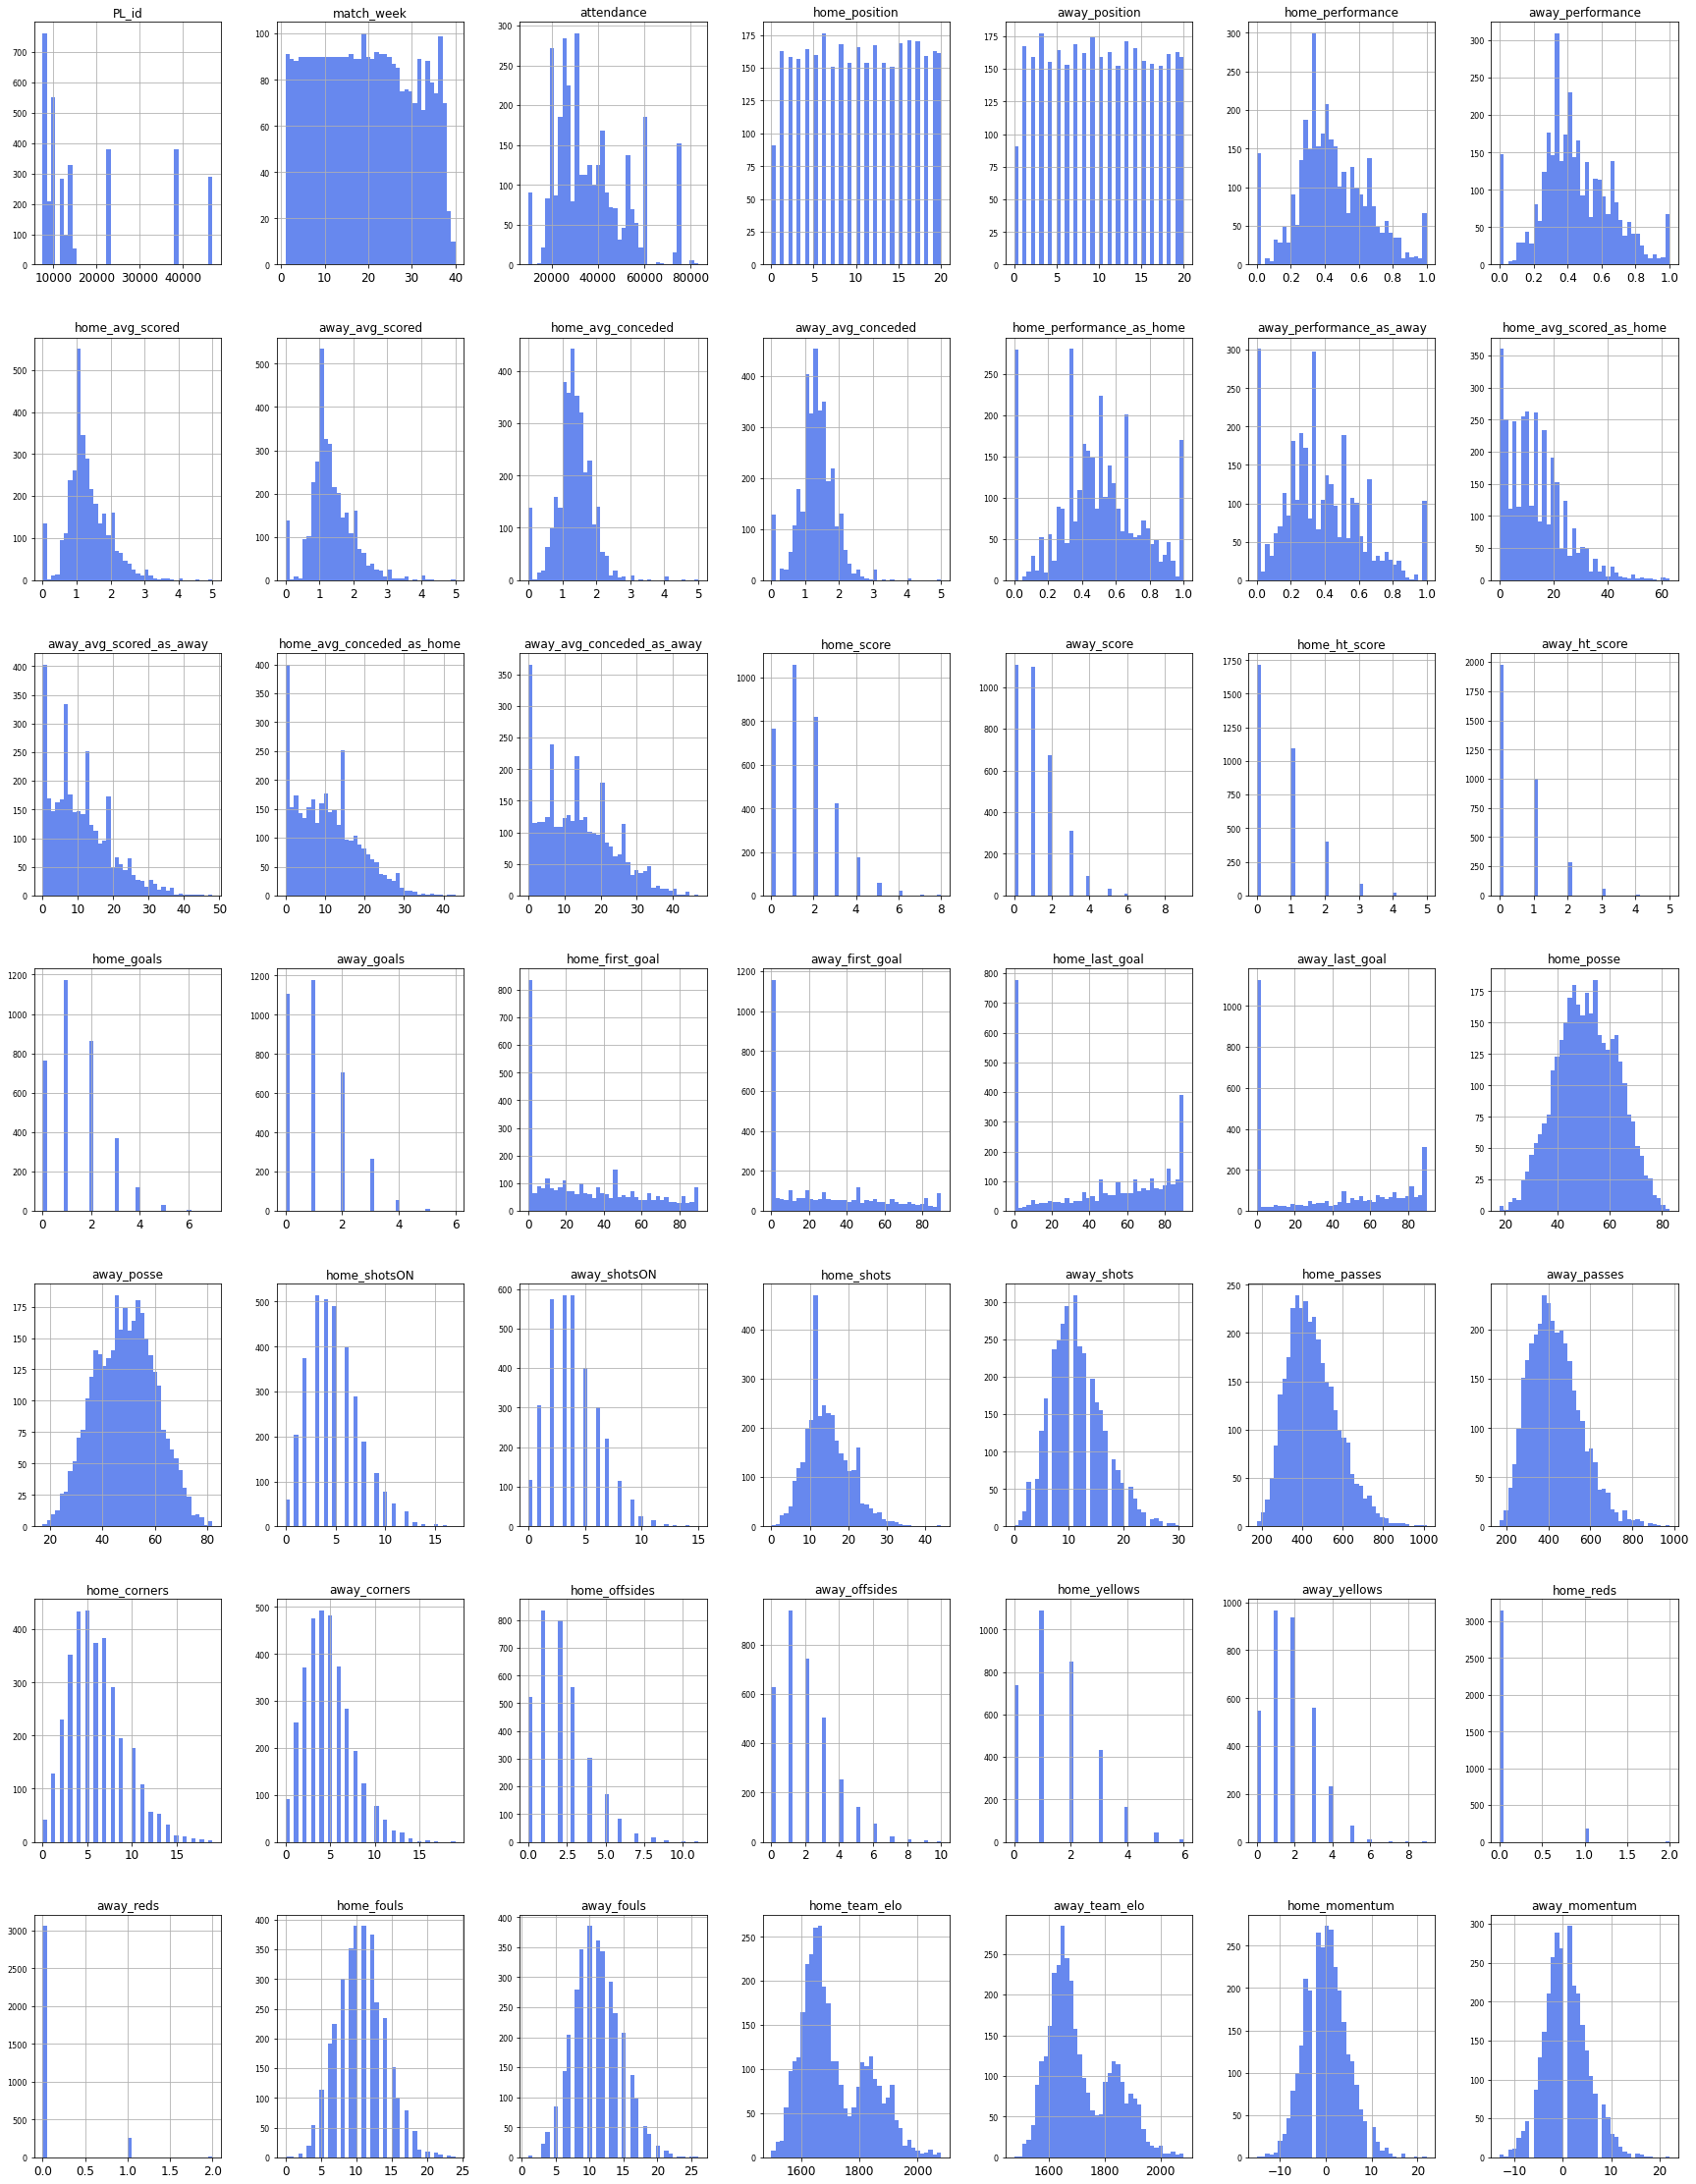

In [1224]:
## Replacing missing values with median
df['home_performance_last_five'].fillna(df['home_performance_last_five'].median(), inplace=True)
df['away_performance_last_five'].fillna(df['away_performance_last_five'].median(), inplace=True)

## These columns are clearly categorical. Let's convert them.

df['home_performance_last_five'] =  df['home_performance_last_five'].astype('category')
df['away_performance_last_five'] =  df['away_performance_last_five'].astype('category')
df_num = df.select_dtypes(['int64','float64'])

df_num.hist(figsize=(30,40), xlabelsize=12, ylabelsize=8, bins=40)
plt.show();

***
### Additional data:

- sofifa data needs to be scraped for player ratings. This has been done using the following code:


df2= pd.DataFrame()


for i in range(0, 30000, 60):
    
    r = requests.get('https://sofifa.com/players', params={'offset':i})
    
    df1 = pd.read_html(r.text)[0]
    
    df2 = df2.append(df1)

df2=df2[~df2.duplicated()]

df2.to_csv('Player_att.csv')

The player data has been exported to a csv file. We will directly use the csv file for this notebook.


- premierleague.com needs to be scraped to get missing home_lineup and away_lineup values.


- club-elo needs to be scraped for club elo ratings. More on elo ratings here https://en.wikipedia.org/wiki/World_Football_Elo_Ratings.

***


In [1225]:
season_counts = (df.groupby(['season'])['result']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     
                     )
season_counts

,season,result,percentage
0,2011/12,home,45.000000
1,2011/12,away,30.526316
2,2011/12,tie,24.473684
3,2012/13,home,43.684211
4,2012/13,tie,28.421053
5,2012/13,away,27.894737
6,2013/14,home,47.105263
7,2013/14,away,32.368421
8,2013/14,tie,20.526316
9,2014/15,home,45.263158


In [1226]:
season_counts= season_counts[season_counts['result']!='tie']

In [1227]:
season_counts['season'].unique()

array(['2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17',
       '2017/18', '2018/19', '2019/20'], dtype=object)

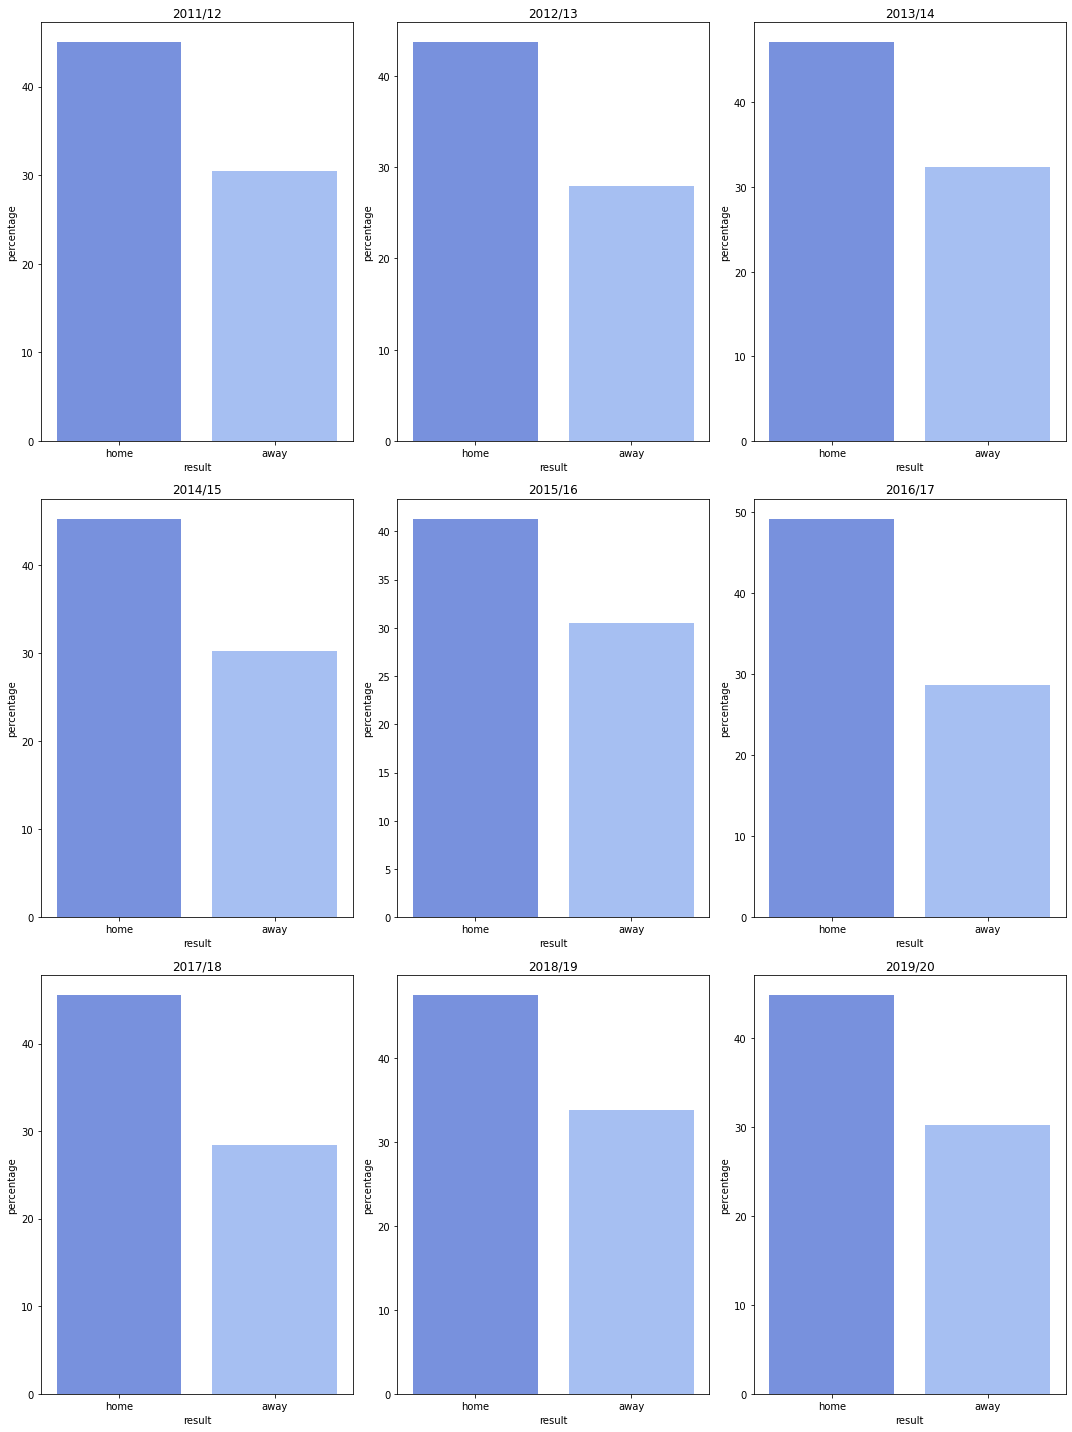

In [1228]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20))
for h,i in enumerate(season_counts['season'].unique()):
    sns.barplot(season_counts[season_counts['season']==i]['result'],season_counts[season_counts['season']==i]['percentage'], ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)

plt.tight_layout()
plt.show()

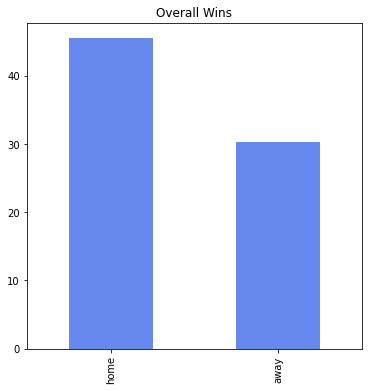

In [1229]:
plt.figure(figsize=(6,6))
df['result'].value_counts(normalize=True)[0:2].mul(100).plot.bar()
plt.title('Overall Wins');

----
### Hypothesis test # 1  : Shots on goal. 
#### Null Hypothesis : Shots On Goal don't have any effect on match result.

In [1230]:
shotsON = pd.DataFrame(columns=['season','win/tie','total_shotsON'])
shotsON['total_shotsON']= df['home_shotsON'] + df['away_shotsON']
shotsON['season']= df['season']
shotsON['win/tie']= df['result'].replace({'home':'win','away':'win'})
shotsON['result']= df['result']
shotsON['home_shotsON']= df['home_shotsON']
shotsON['away_shotsON']= df['away_shotsON']

In [1231]:
shotsON

,season,win/tie,total_shotsON,result,home_shotsON,away_shotsON
0,2011/12,win,6.0,away,2.0,4.0
1,2011/12,tie,6.0,tie,5.0,1.0
2,2011/12,tie,7.0,tie,3.0,4.0
3,2011/12,tie,3.0,tie,1.0,2.0
4,2011/12,win,3.0,away,1.0,2.0
...,...,...,...,...,...,...
3322,2019/20,win,10.0,home,6.0,4.0
3323,2019/20,win,10.0,home,6.0,4.0
3324,2019/20,win,9.0,home,4.0,5.0
3325,2019/20,win,10.0,away,3.0,7.0


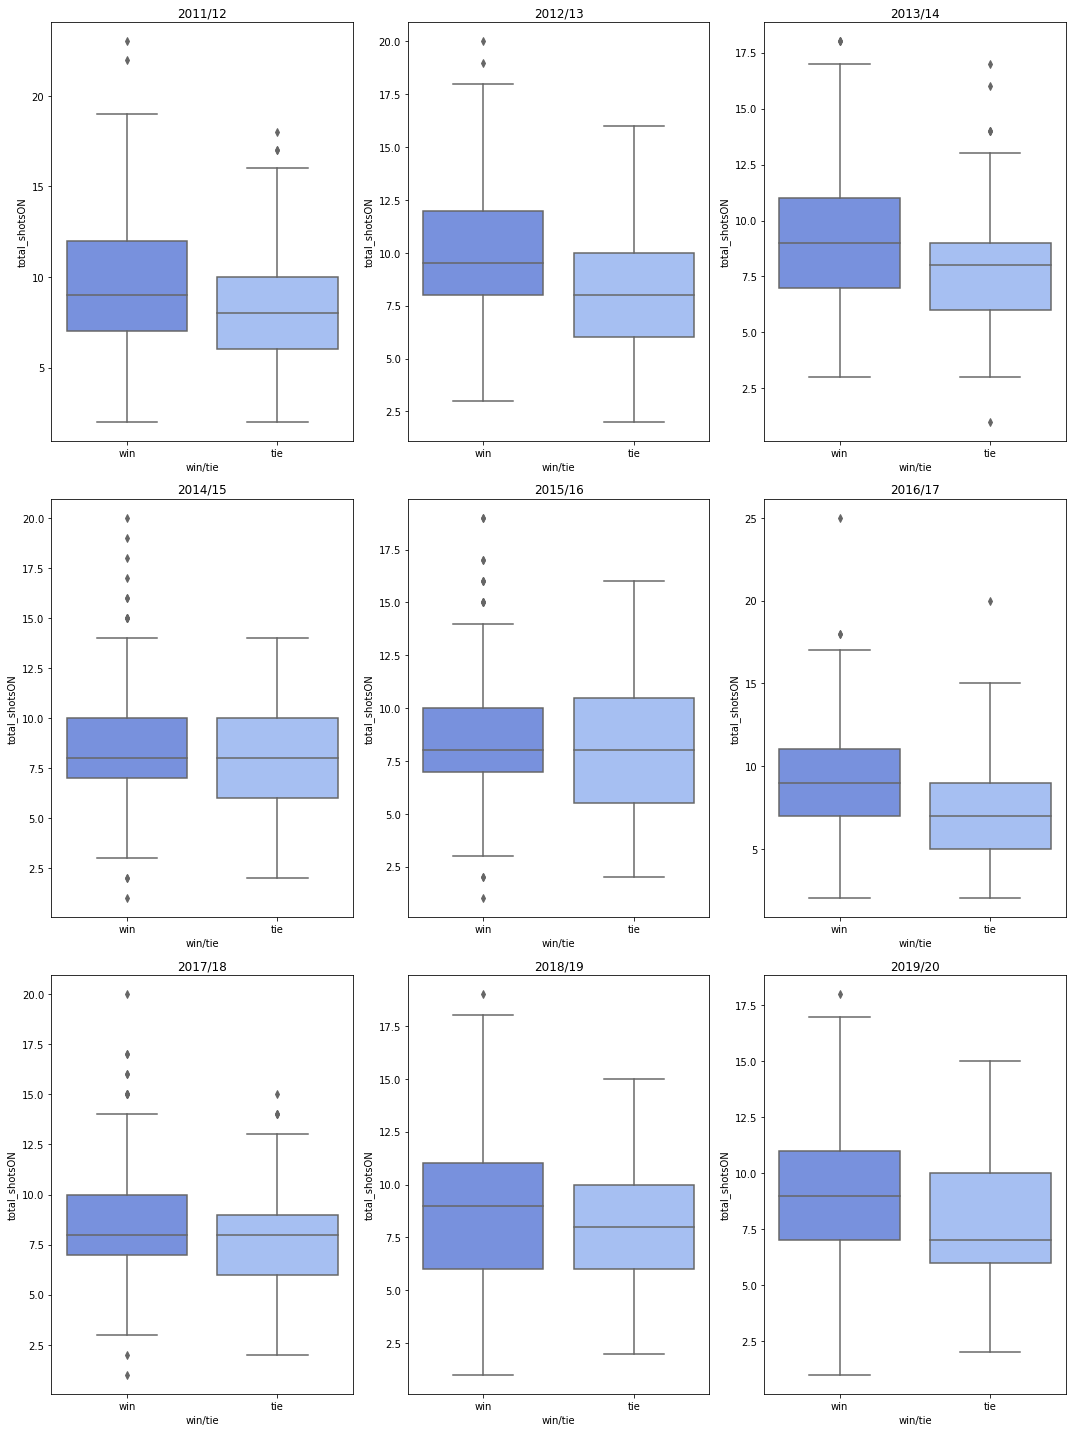

In [1232]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20))
for h,i in enumerate(shotsON['season'].unique()):
    sns.boxplot(shotsON[shotsON['season']==i]['win/tie'].sort_values(ascending=False),shotsON[shotsON['season']==i]['total_shotsON'], ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)

plt.tight_layout()
plt.show()

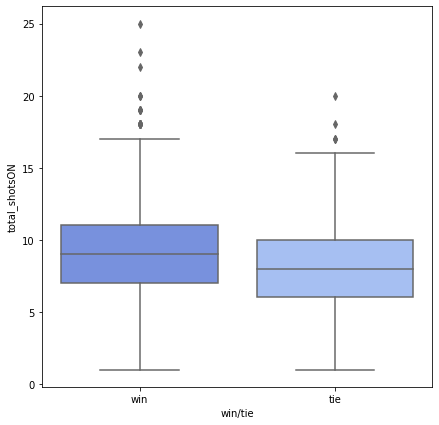

In [1233]:
plt.figure(figsize=(7,7))
sns.boxplot('win/tie', 'total_shotsON', data=shotsON)
plt.show();

In [1234]:
shotsON.groupby('win/tie')['total_shotsON'].mean()

win/tie
tie    7.951553
win    8.994449
Name: total_shotsON, dtype: float64

In [1235]:
win = shotsON[shotsON['win/tie']=='win']

In [1236]:
tie = shotsON[shotsON['win/tie']=='tie']

In [1237]:
win_sample= win.sample(frac=1, replace=True, random_state=50)
tie_sample= tie.sample(frac=1, replace=True, random_state=50)

In [1238]:
from scipy.stats import ttest_ind
ttest_ind(win_sample['total_shotsON'], tie_sample['total_shotsON'])

Ttest_indResult(statistic=5.864702127296318, pvalue=4.940006032365092e-09)

##### Since the t-test null hypothesis is that the means of the 2 sample populations is the same and our p-value<0.05, we reject the null hypothesis. This feature for shotsON goal might be important for result classification.

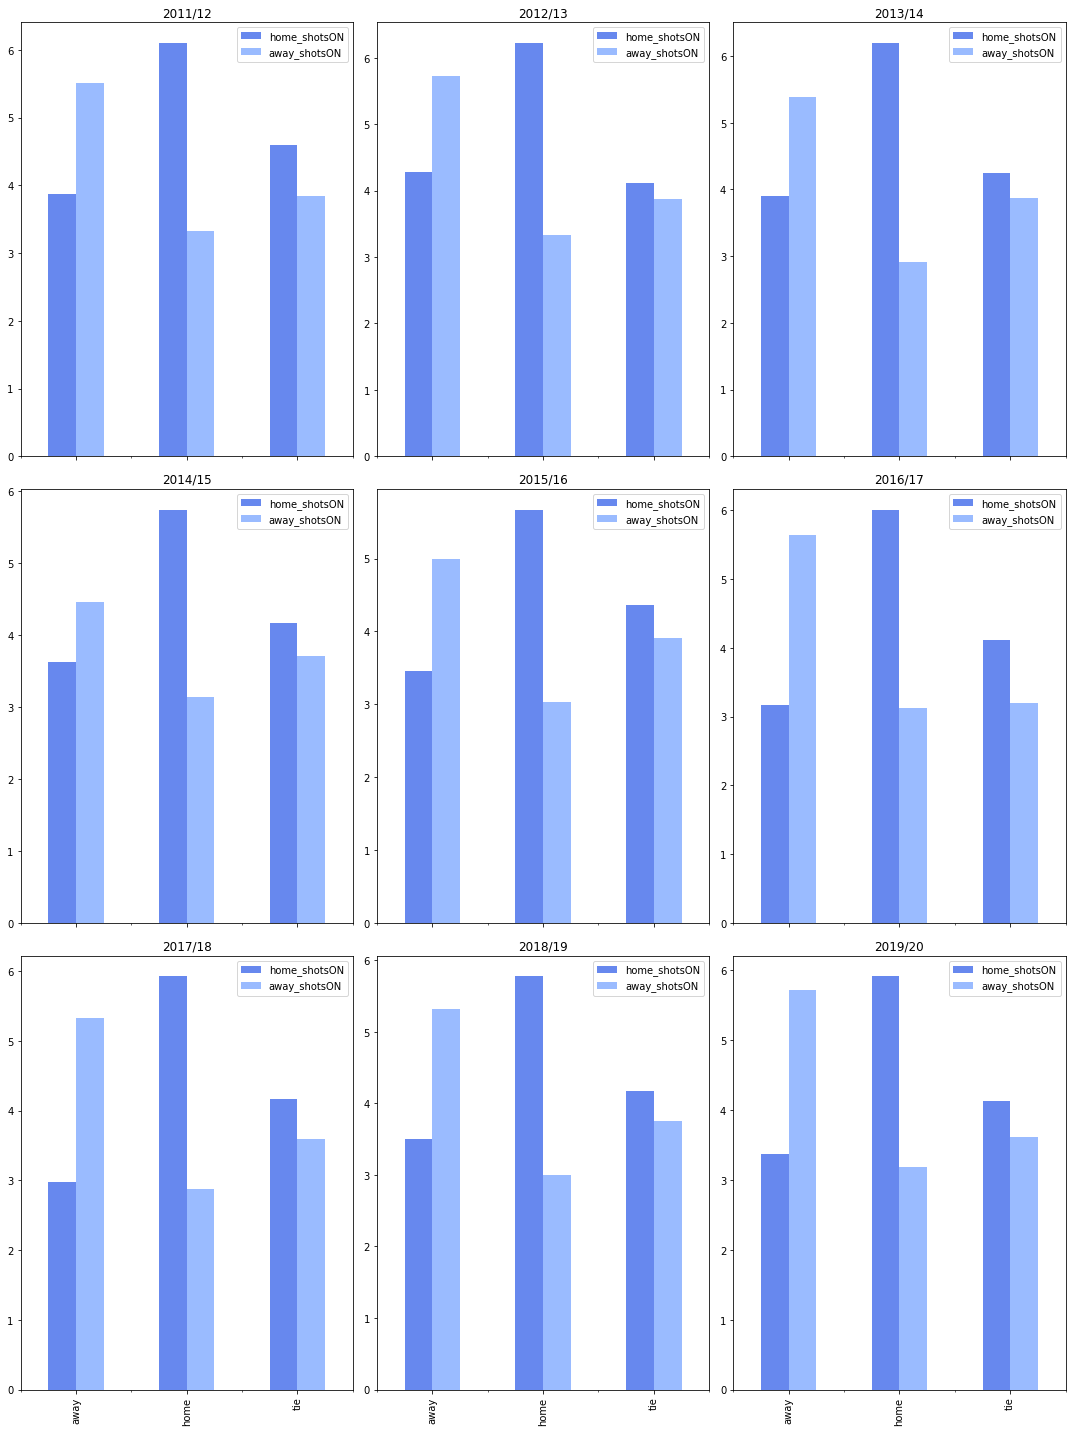

In [1239]:
## Let's see the difference in home shots and away shots for different results.
shotsdf = shotsON.groupby(['season','result'], as_index=False)[['home_shotsON', 'away_shotsON']].mean()
fig, axes= plt.subplots(3,3, figsize=(15,20), sharex=True)
for h,i in enumerate(shotsdf['season'].unique()):
    shotsdf[shotsdf['season']==i].plot(kind='bar', ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)


plt.xticks(range(3), ['away','home','tie']);
    
plt.tight_layout()
plt.show()


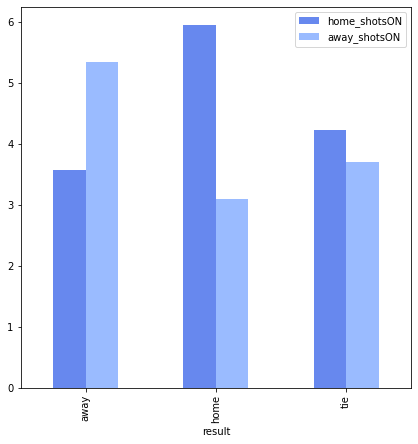

In [1240]:
shotsdf.groupby('result')[['home_shotsON', 'away_shotsON']].mean().plot(kind='bar', figsize=(7,7));

----



### Hypothesis test # 2. Total passes. 
#### Null Hypothesis: Number of passes in a match has no effect on the match result.

In [1241]:
passes = pd.DataFrame(columns=['season','win/tie','total_passes'])
passes['season'] = df['season']
passes['win/tie'] = df['result'].replace({'home':'win','away':'win'})
passes['total_passes'] = df['home_passes'] + df['away_passes']
passes['result']= df['result']
passes['home_passes']= df['home_passes']
passes['away_passes']= df['away_passes']
passes

,season,win/tie,total_passes,result,home_passes,away_passes
0,2011/12,win,628.0,away,330.0,298.0
1,2011/12,tie,771.0,tie,419.0,352.0
2,2011/12,tie,796.0,tie,480.0,316.0
3,2011/12,tie,868.0,tie,320.0,548.0
4,2011/12,win,868.0,away,320.0,548.0
...,...,...,...,...,...,...
3322,2019/20,win,975.0,home,729.0,246.0
3323,2019/20,win,1055.0,home,294.0,761.0
3324,2019/20,win,878.0,home,359.0,519.0
3325,2019/20,win,798.0,away,298.0,500.0


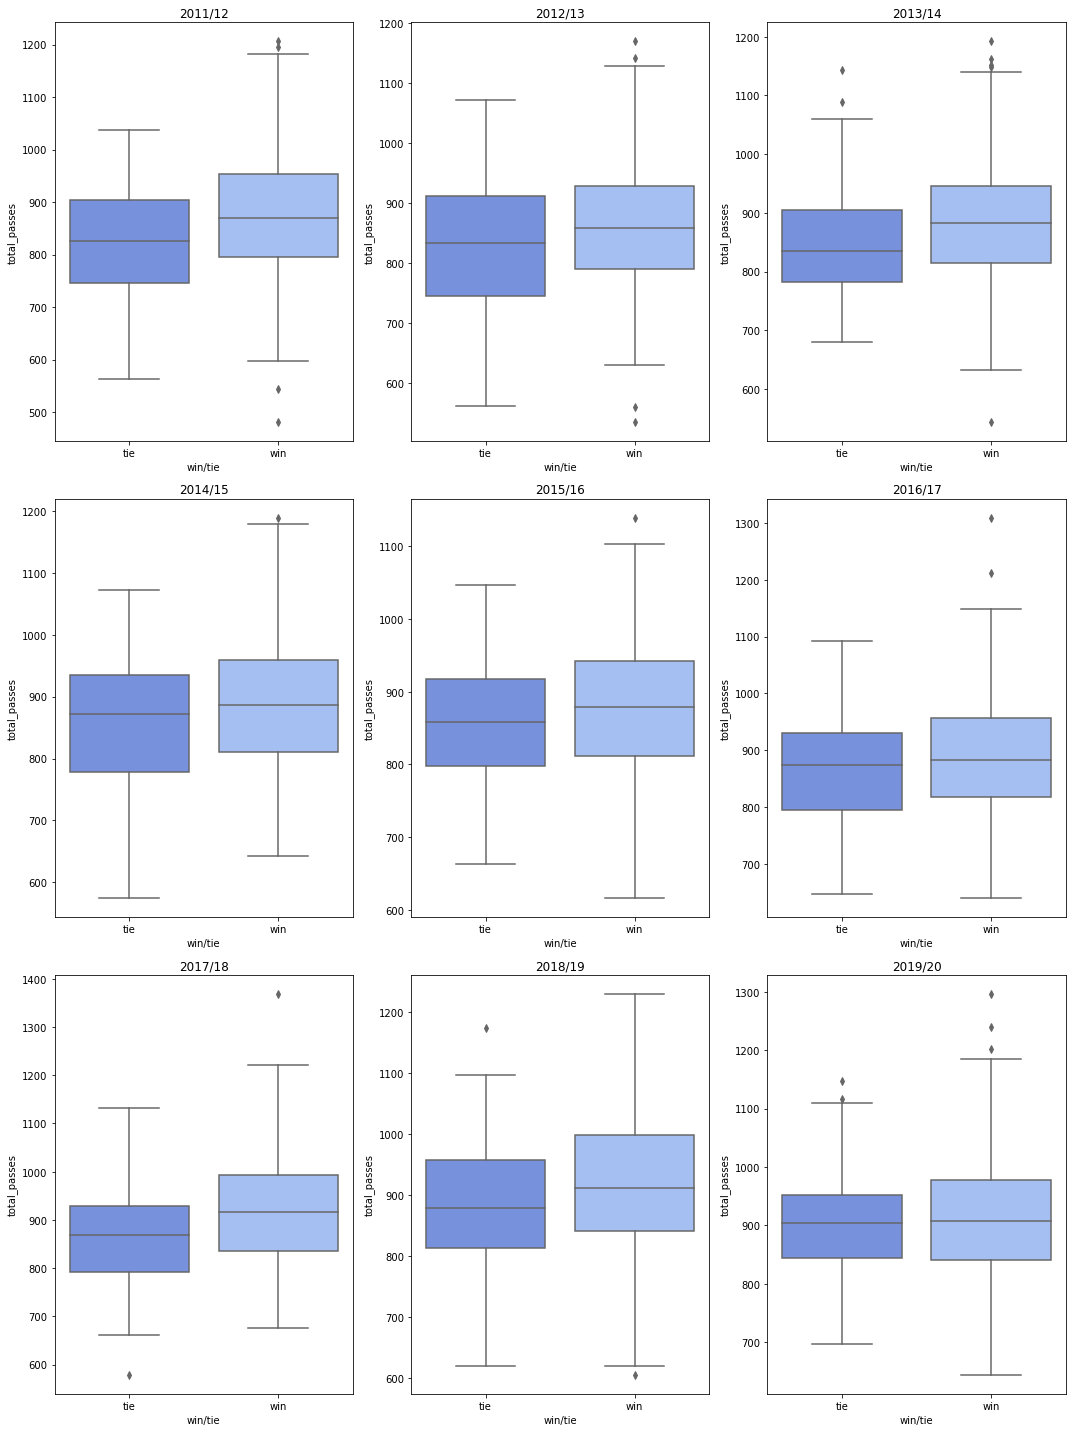

In [1242]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20))
for h,i in enumerate(passes['season'].unique()):
    sns.boxplot(passes[passes['season']==i]['win/tie'].sort_values(),passes[passes['season']==i]['total_passes'], ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)

plt.tight_layout()
plt.show()

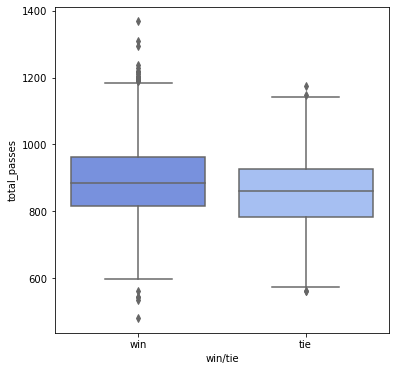

In [1243]:
plt.figure(figsize=(6,6))
sns.boxplot('win/tie', 'total_passes', data= passes)
plt.show();

In [1244]:
win_passes = passes[passes['win/tie']=='win']
tie_passes = passes[passes['win/tie']=='tie']
win_samples = win_passes.sample(frac=1, replace= True)
tie_samples = tie_passes.sample(frac=1, replace= True)

In [1245]:
ttest_ind(win_samples['total_passes'],tie_samples['total_passes'])

Ttest_indResult(statistic=8.313971528208423, pvalue=1.3326238252860112e-16)

#### The t- test is statistically significant, hence we must reject the null hypothesis. Total passes might be a good feature to have for our ML algo. 

In [1246]:
passes_df= passes.groupby(['season','result'], as_index= False)[['home_passes','away_passes']].mean()

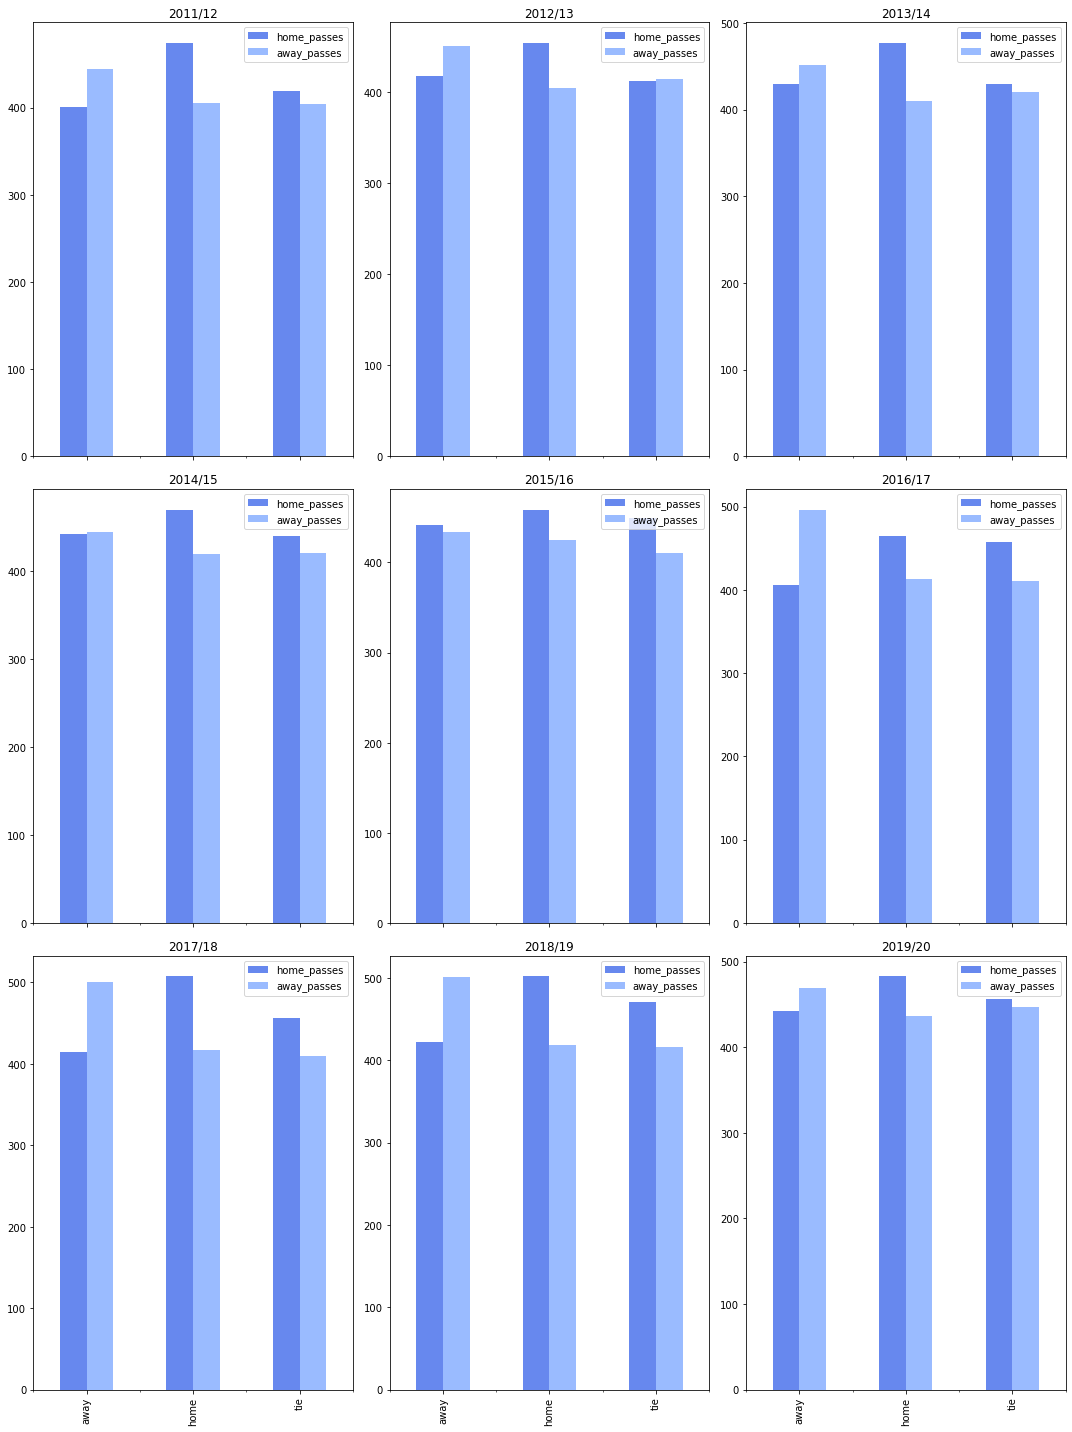

In [1247]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20), sharex=True)
for h,i in enumerate(passes_df['season'].unique()):
    passes_df[passes_df['season']==i].plot(kind='bar', ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)
plt.xticks(range(3),['away','home','tie'])
plt.tight_layout()
plt.show()

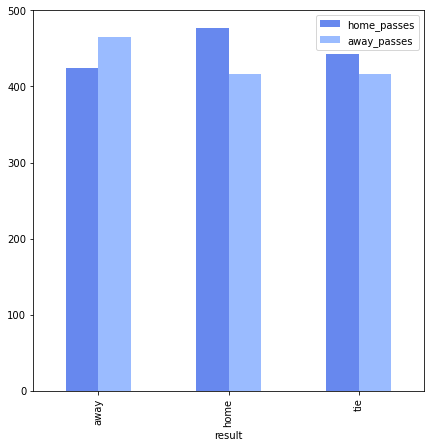

In [1248]:
passes_df.groupby('result')[['home_passes', 'away_passes']].mean().plot(kind='bar', figsize=(7,7));


----

### Hypothesis Test # 3 Total corners.

#### Null Hypothesis: No. of corners have no effect on match result. 

In [1249]:
corners = pd.DataFrame(columns=['season','win/tie','total_corners'])
corners['season'] = df['season']
corners['win/tie'] = df['result'].replace({'home':'win','away':'win'})
corners['total_corners'] = df['home_corners'] + df['away_corners']
corners['result']= df['result']
corners['home_corners']= df['home_corners']
corners['away_corners']= df['away_corners']
corners

,season,win/tie,total_corners,result,home_corners,away_corners
0,2011/12,win,18.0,away,12.0,6.0
1,2011/12,tie,5.0,tie,2.0,3.0
2,2011/12,tie,9.0,tie,6.0,3.0
3,2011/12,tie,7.0,tie,2.0,5.0
4,2011/12,win,7.0,away,2.0,5.0
...,...,...,...,...,...,...
3322,2019/20,win,13.0,home,9.0,4.0
3323,2019/20,win,13.0,home,2.0,11.0
3324,2019/20,win,15.0,home,10.0,5.0
3325,2019/20,win,13.0,away,5.0,8.0


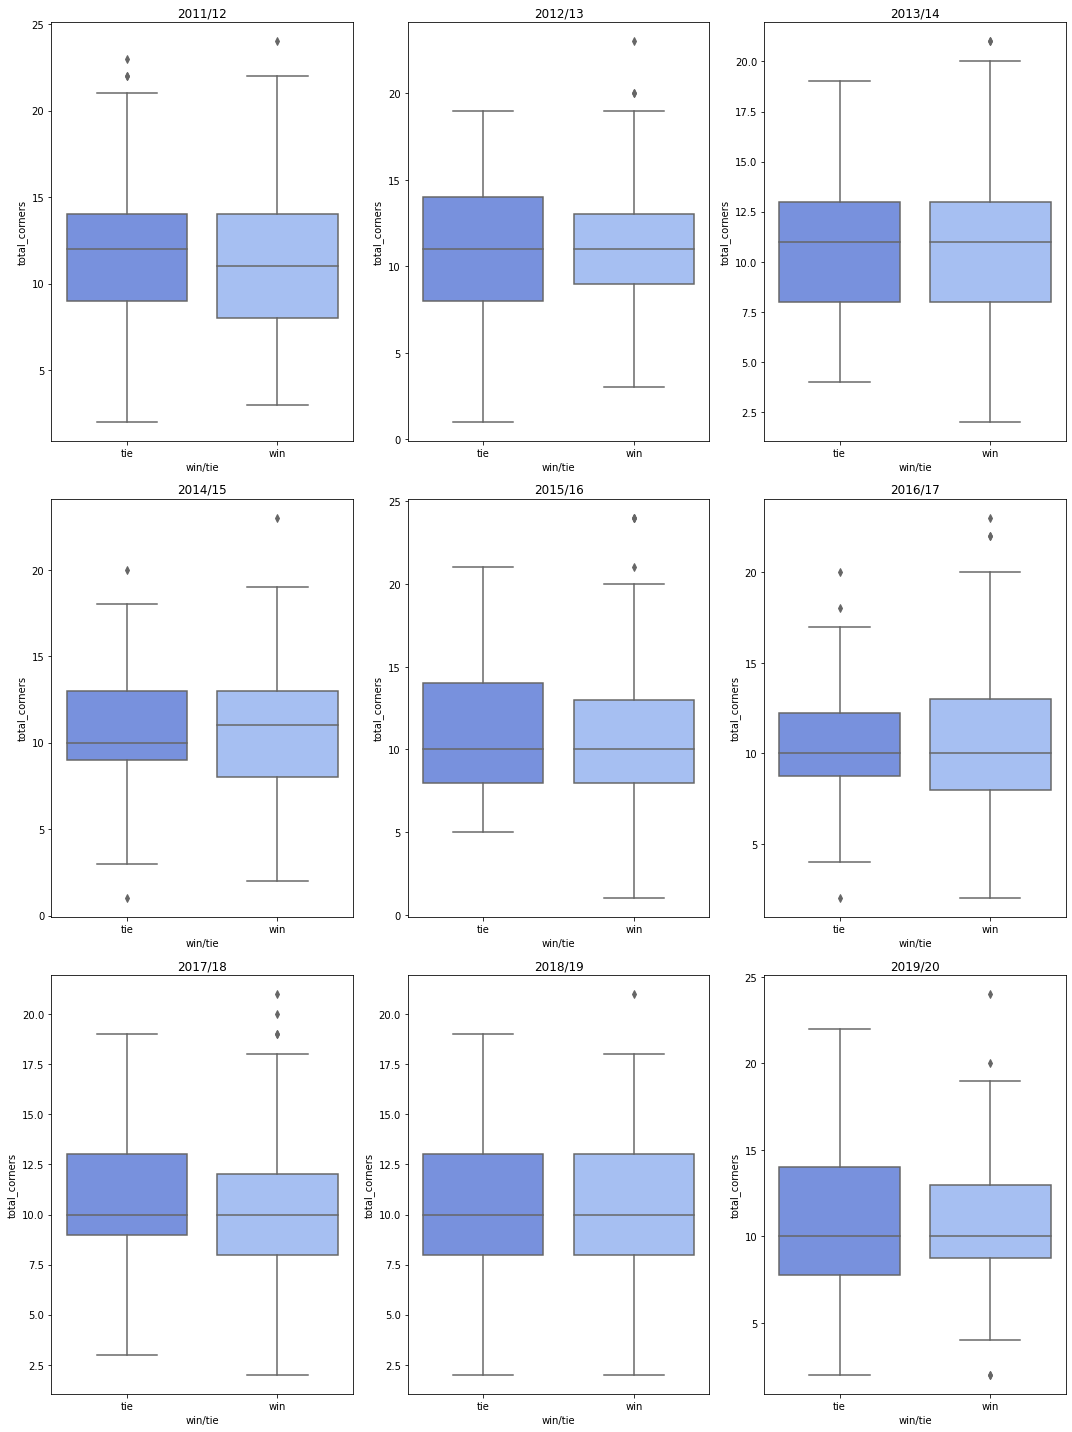

In [1250]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20))
for h,i in enumerate(corners['season'].unique()):
    sns.boxplot(corners[corners['season']==i]['win/tie'].sort_values(),corners[corners['season']==i]['total_corners'], ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)

plt.tight_layout()
plt.show()

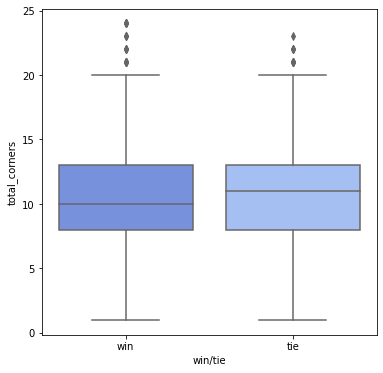

In [1251]:
plt.figure(figsize=(6,6))
sns.boxplot('win/tie', 'total_corners', data= corners)
plt.show();

In [1252]:
win_corners = corners[corners['win/tie']=='win']
tie_corners = corners[corners['win/tie']=='tie']
win_samples = win_corners.sample(frac=1, replace= True)
tie_samples = tie_corners.sample(frac=1, replace= True)

In [1253]:
ttest_ind(win_samples['total_corners'],tie_samples['total_corners'])

Ttest_indResult(statistic=-1.812291469584486, pvalue=0.07003133370834688)

#### The p-value here is greater than 0.05. Hence both can be assumed to originate from the same population. 
#### This might not be a good feature for our model.





----
### Hypothesis test # 4 : Home League Position

#### Null Hypothesis: Home league positions are not related with the match result.


In [1254]:
home_pos = pd.DataFrame(columns=['season','win/tie','home_position'])
home_pos['season'] = df['season']
home_pos['win/tie'] = df['result'].replace({'home':'win','away':'win'})
home_pos['home_position'] = df['home_position']
home_pos['result']= df['result']
home_pos= home_pos[home_pos['home_position'] != 0.0] ## Removing rows with home position = 0
home_pos

,season,win/tie,home_position,result
9,2011/12,win,10.0,away
10,2011/12,win,10.0,home
11,2011/12,win,10.0,home
12,2011/12,win,18.0,away
13,2011/12,win,6.0,away
...,...,...,...,...
3322,2019/20,win,1.0,home
3323,2019/20,win,5.0,home
3324,2019/20,win,8.0,home
3325,2019/20,win,13.0,away


#### Home position here is a categorical variable, hence we will use a chi-square test for independence to check our null hypothesis 

In [1255]:
from scipy.stats import chi2_contingency


In [1256]:
pos_table = pd.crosstab(home_pos['home_position'], home_pos['win/tie'])
pos_table.T

home_position,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
win/tie,,,,,,,,,,,,,,,,,,,,
tie,18,28,32,36,34,50,35,41,48,41,44,42,43,47,38,40,36,40,39,50
win,145,130,125,128,126,126,116,127,106,125,110,125,111,104,131,131,134,119,124,111


In [1257]:
chi2_contingency(pos_table)
## Since p-value<0.05 we reject the null hypothesis.

(39.56996609344344,
 0.003724979939827762,
 19,
 array([[ 39.38998764, 123.61001236],
        [ 38.18170581, 119.81829419],
        [ 37.94004944, 119.05995056],
        [ 39.631644  , 124.368356  ],
        [ 38.66501854, 121.33498146],
        [ 42.5315204 , 133.4684796 ],
        [ 36.49011125, 114.50988875],
        [ 40.59826947, 127.40173053],
        [ 37.21508035, 116.78491965],
        [ 40.11495674, 125.88504326],
        [ 37.21508035, 116.78491965],
        [ 40.3566131 , 126.6433869 ],
        [ 37.21508035, 116.78491965],
        [ 36.49011125, 114.50988875],
        [ 40.83992583, 128.16007417],
        [ 41.32323857, 129.67676143],
        [ 41.0815822 , 128.9184178 ],
        [ 38.42336218, 120.57663782],
        [ 39.38998764, 123.61001236],
        [ 38.90667491, 122.09332509]]))

#### Home position might be an important variable in our model.

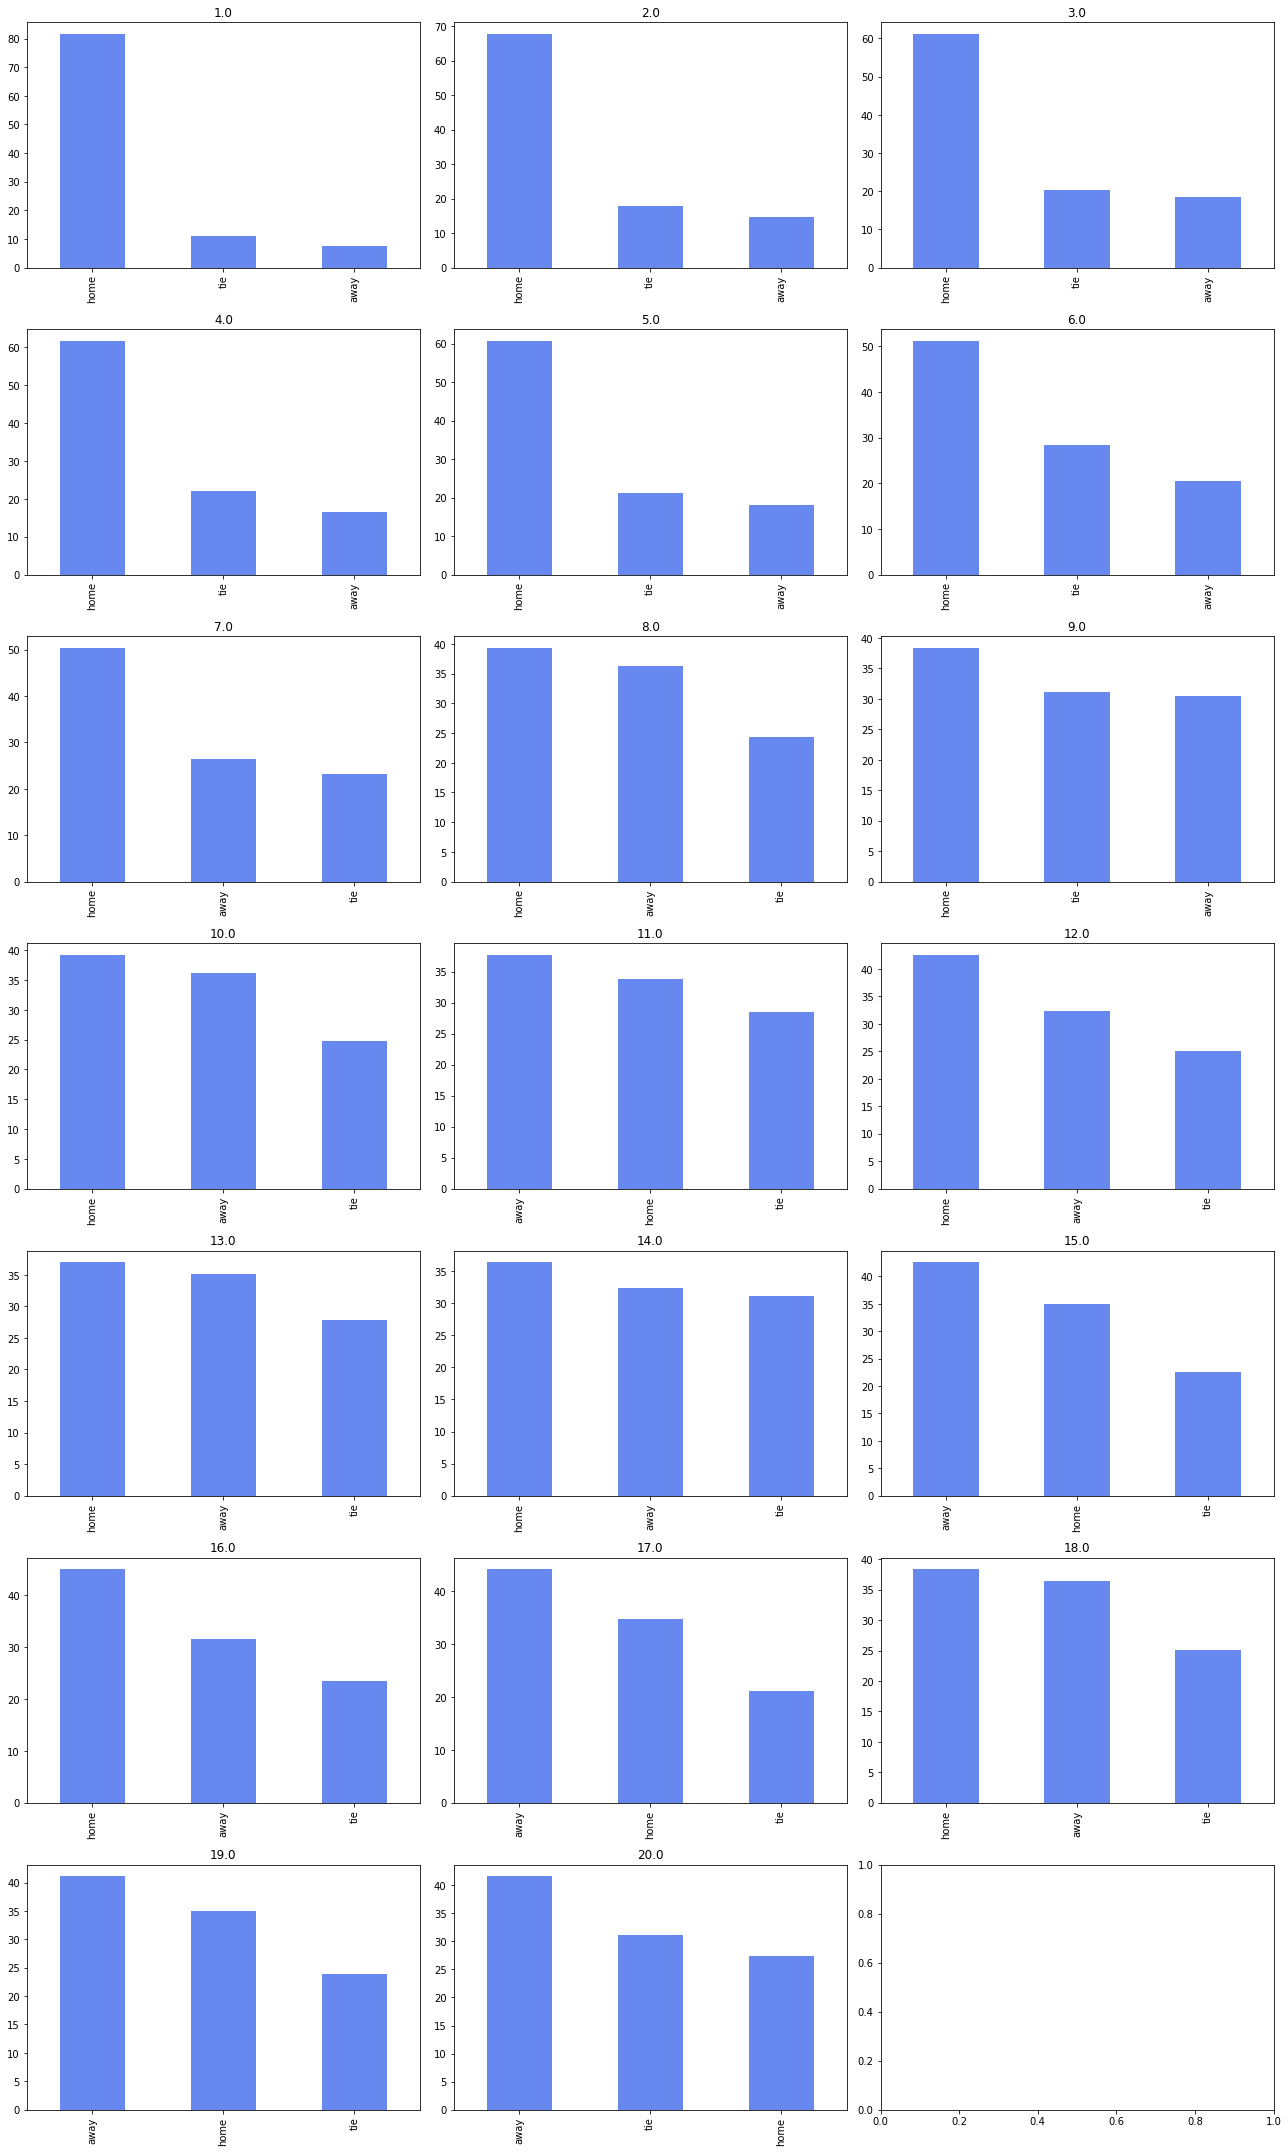

In [1258]:
fig, axes = plt.subplots(7,3, figsize=(18,30))
for i,j in enumerate(home_pos['home_position'].sort_values().unique()):
    home_pos[home_pos['home_position']==j]['result'].value_counts(normalize=True).mul(100).plot(kind='bar', ax=axes[int(np.floor(i/3)),int(i-3*np.floor(i/3))] )
    axes[int(np.floor(i/3)),int(i-3*np.floor(i/3))].set_title(j)

plt.tight_layout()    
plt.show()    

In [1259]:
home_pos['home_position'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

----

### Hypothesis test # 5 : Away league position
#### Null Hypothesis: Away league position is independent of match result

In [1260]:
away_pos = pd.DataFrame(columns=['season','win/tie','away_position'])
away_pos['season'] = df['season']
away_pos['win/tie'] = df['result'].replace({'home':'win','away':'win'})
away_pos['away_position'] = df['away_position']
away_pos['result']= df['result']
away_pos= away_pos[away_pos['away_position'] != 0.0] ## Removing rows with home position = 0
away_pos

,season,win/tie,away_position,result
9,2011/12,win,6.0,away
10,2011/12,win,16.0,home
11,2011/12,win,16.0,home
12,2011/12,win,19.0,away
13,2011/12,win,10.0,away
...,...,...,...,...
3322,2019/20,win,18.0,home
3323,2019/20,win,2.0,home
3324,2019/20,win,20.0,home
3325,2019/20,win,14.0,away


In [1261]:
pos_table_away = pd.crosstab(away_pos['away_position'], away_pos['win/tie'])
pos_table_away.T

away_position,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
win/tie,,,,,,,,,,,,,,,,,,,,
tie,43,29,39,45,40,38,45,34,41,42,47,29,41,49,42,40,38,26,34,40
win,124,130,138,110,124,115,124,128,133,117,116,123,130,117,114,114,114,135,129,119


In [1262]:
chi2_contingency(pos_table_away)
## Since p-value>0.05 we fail to reject the null hypothesis.

(22.05203244125382,
 0.28167433746026527,
 19,
 array([[ 40.3566131 , 126.6433869 ],
        [ 38.42336218, 120.57663782],
        [ 42.77317676, 134.22682324],
        [ 37.45673671, 117.54326329],
        [ 39.631644  , 124.368356  ],
        [ 36.97342398, 116.02657602],
        [ 40.83992583, 128.16007417],
        [ 39.14833127, 122.85166873],
        [ 42.04820766, 131.95179234],
        [ 38.42336218, 120.57663782],
        [ 39.38998764, 123.61001236],
        [ 36.73176761, 115.26823239],
        [ 41.32323857, 129.67676143],
        [ 40.11495674, 125.88504326],
        [ 37.69839308, 118.30160692],
        [ 37.21508035, 116.78491965],
        [ 36.73176761, 115.26823239],
        [ 38.90667491, 122.09332509],
        [ 39.38998764, 123.61001236],
        [ 38.42336218, 120.57663782]]))

#### Away league position might not be a good feature for our model.

----

### Hypothesis test # 6 : Number of yellow cards
#### Null hypothesis: Number of yellow cards in a game has no relation with the result.

In [1263]:
yellow = pd.DataFrame(columns=['season','win/tie','total_yellowcards'])
yellow['season'] = df['season']
yellow['win/tie'] = df['result'].replace({'home':'win','away':'win'})
yellow['total_yellowcards'] = df['home_yellows'] + df['away_yellows']
yellow['result']= df['result']
yellow['home_yellows']= df['home_yellows']
yellow['away_yellows']= df['away_yellows']
yellow

,season,win/tie,total_yellowcards,result,home_yellows,away_yellows
0,2011/12,win,6.0,away,4.0,2.0
1,2011/12,tie,6.0,tie,2.0,4.0
2,2011/12,tie,8.0,tie,4.0,4.0
3,2011/12,tie,8.0,tie,3.0,5.0
4,2011/12,win,8.0,away,3.0,5.0
...,...,...,...,...,...,...
3322,2019/20,win,1.0,home,0.0,1.0
3323,2019/20,win,6.0,home,2.0,4.0
3324,2019/20,win,0.0,home,0.0,0.0
3325,2019/20,win,3.0,away,0.0,3.0


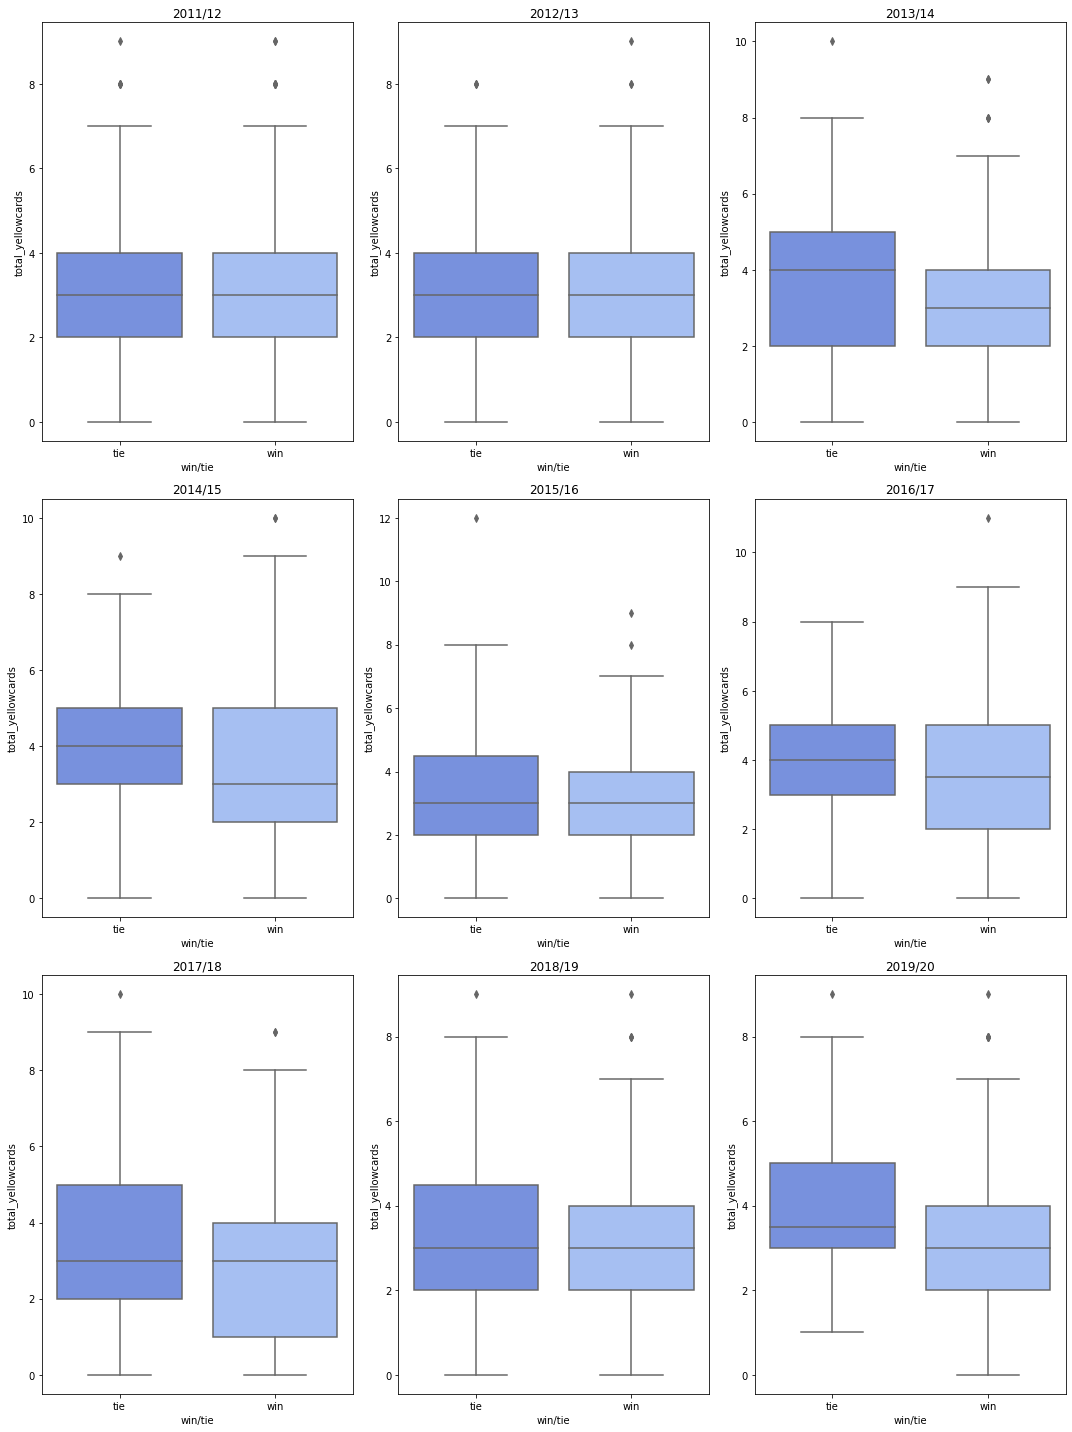

In [1264]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20))
for h,i in enumerate(yellow['season'].unique()):
    sns.boxplot(yellow[yellow['season']==i]['win/tie'].sort_values(),yellow[yellow['season']==i]['total_yellowcards'], ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)

plt.tight_layout()
plt.show()

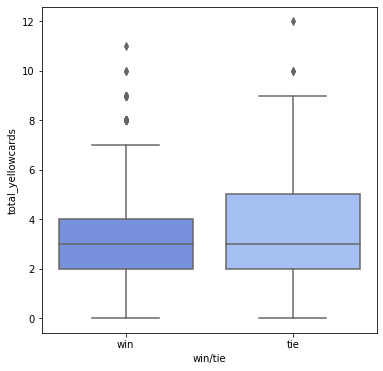

In [1265]:
plt.figure(figsize=(6,6))
sns.boxplot('win/tie', 'total_yellowcards', data= yellow)
plt.show();

In [1266]:
## Let's do a t-test since there isn't a very noticeable difference in the boxplots.
win_yellow = yellow[yellow['win/tie']=='win']
tie_yellow = yellow[yellow['win/tie']=='tie']
win_samples = win_yellow.sample(frac=1, replace= True)
tie_samples = tie_yellow.sample(frac=1, replace= True)


In [1267]:
ttest_ind(win_samples['total_yellowcards'], tie_samples['total_yellowcards'])

Ttest_indResult(statistic=-3.2040392606318306, pvalue=0.001367949395899571)

#### The results show that there might be a small relation between total yellow cards and the match result.

In [1268]:
yellow_df= yellow.groupby(['season','result'], as_index= False)[['home_yellows','away_yellows']].mean()

In [1269]:
yellow_df

,season,result,home_yellows,away_yellows
0,2011/12,away,1.646552,1.629310
1,2011/12,home,1.233918,1.690058
2,2011/12,tie,1.311828,1.946237
3,2012/13,away,1.566038,1.726415
4,2012/13,home,1.198795,1.722892
5,2012/13,tie,1.379630,1.814815
6,2013/14,away,1.634146,1.772358
7,2013/14,home,1.156425,1.692737
8,2013/14,tie,1.743590,1.974359
9,2014/15,away,1.521739,1.921739


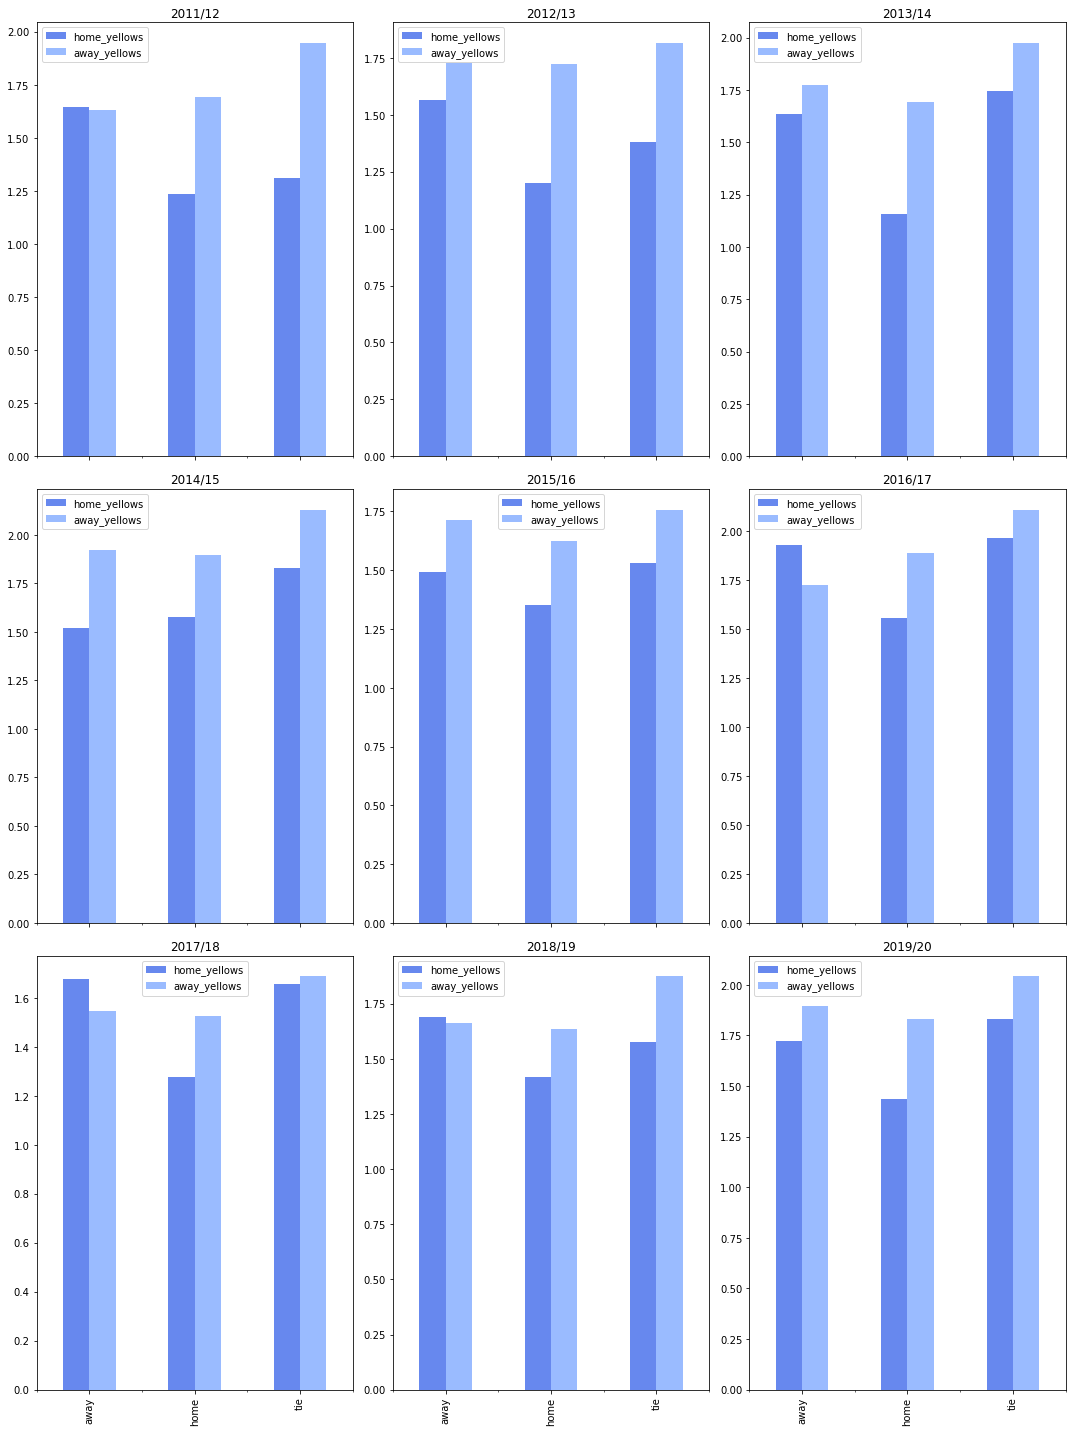

In [1270]:
## Percentage of home/away wins by season
fig, axes= plt.subplots(3,3, figsize=(15,20), sharex=True)
for h,i in enumerate(yellow_df['season'].unique()):
    yellow_df[yellow_df['season']==i].plot(kind='bar', ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)
plt.xticks(range(3),['away','home','tie'])
plt.tight_layout()
plt.show()

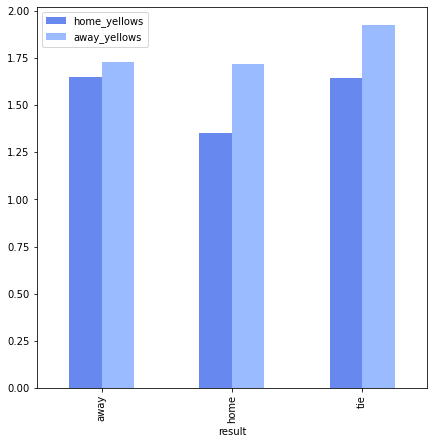

In [1271]:
yellow_df.groupby('result')[['home_yellows', 'away_yellows']].mean().plot(kind='bar', figsize=(7,7));

----

### Hypothesis test # 7 :Number of Red cards
#### Null Hypothesis: Number of red cards has no relation with the match result.

In [1272]:
red = pd.DataFrame(columns=['season','win/tie','total_redcards'])
red['season'] = df['season']
red['win/tie'] = df['result'].replace({'home':'win','away':'win'})
red['total_redcards'] = df['home_reds'] + df['away_reds']
red['result']= df['result']
red['home_reds']= df['home_reds']
red['away_reds']= df['away_reds']
red

,season,win/tie,total_redcards,result,home_reds,away_reds
0,2011/12,win,0.0,away,0.0,0.0
1,2011/12,tie,0.0,tie,0.0,0.0
2,2011/12,tie,0.0,tie,0.0,0.0
3,2011/12,tie,1.0,tie,0.0,1.0
4,2011/12,win,1.0,away,0.0,1.0
...,...,...,...,...,...,...
3322,2019/20,win,0.0,home,0.0,0.0
3323,2019/20,win,0.0,home,0.0,0.0
3324,2019/20,win,0.0,home,0.0,0.0
3325,2019/20,win,1.0,away,1.0,0.0


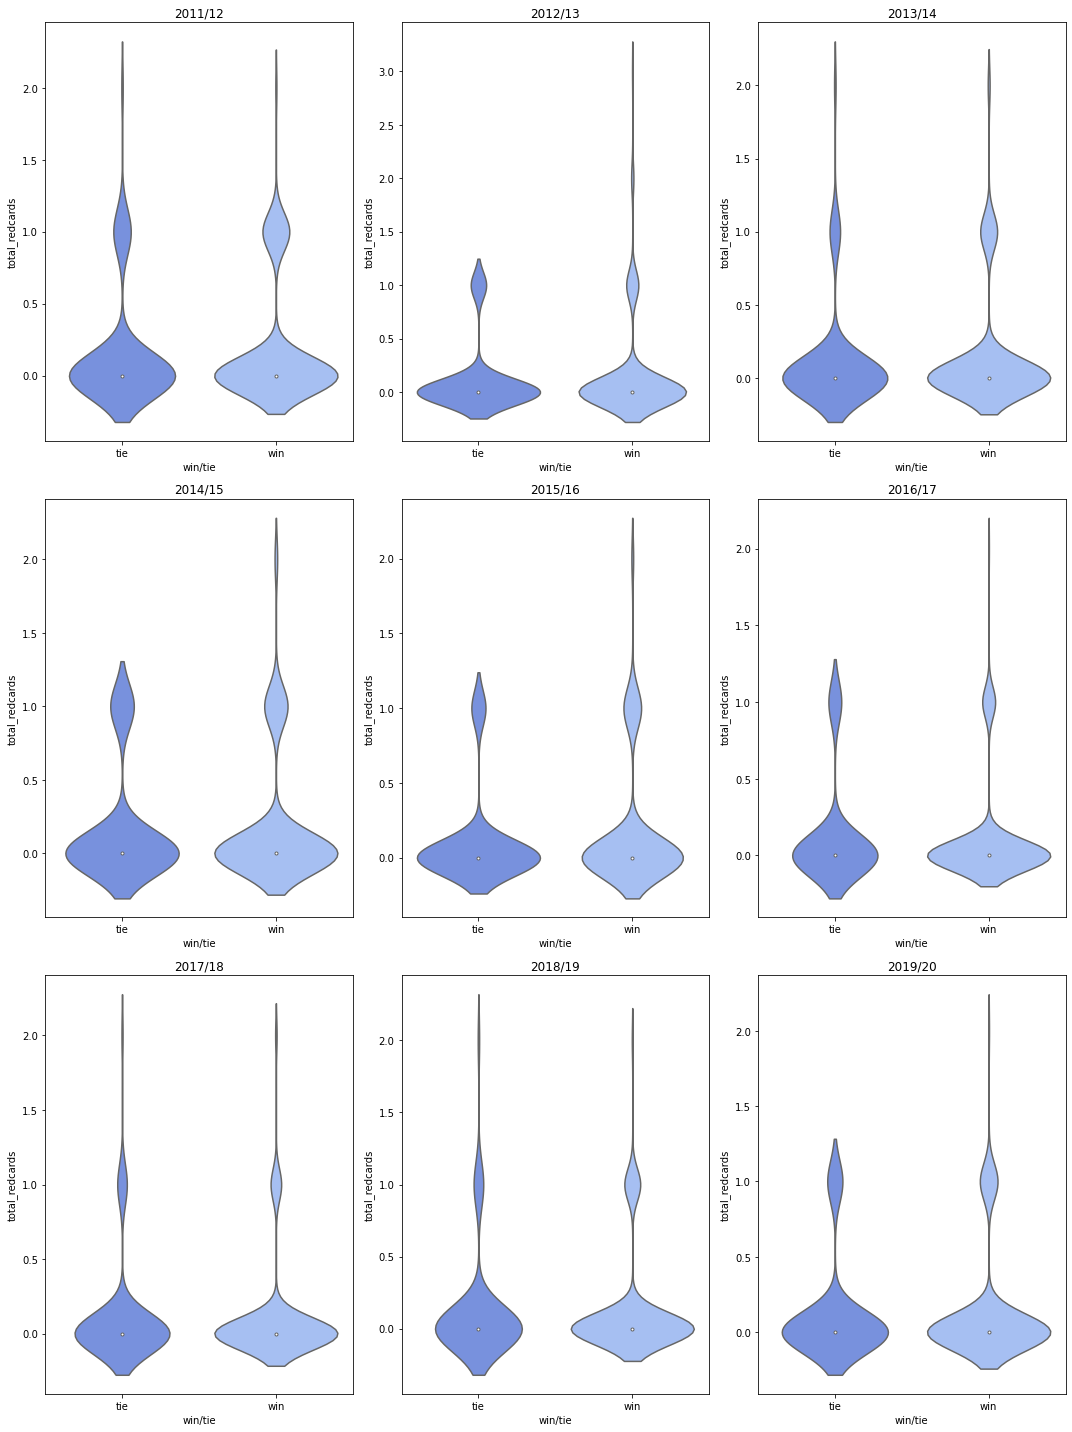

In [1273]:
## Percentage of wins/tie by season
fig, axes= plt.subplots(3,3, figsize=(15,20))
for h,i in enumerate(red['season'].unique()):
    sns.violinplot(red[red['season']==i]['win/tie'].sort_values(),red[red['season']==i]['total_redcards'], ax=axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))])
    axes[int(np.floor(h/3)),int(h-3*np.floor(h/3))].set_title(i)

plt.tight_layout()
plt.show()

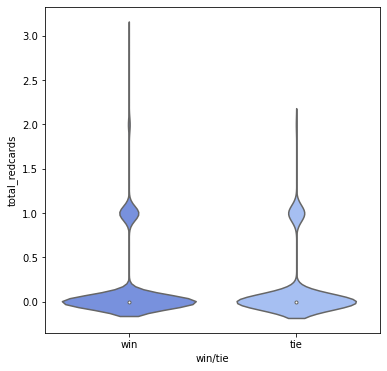

In [1274]:
plt.figure(figsize=(6,6))
sns.violinplot('win/tie', 'total_redcards', data= red)
plt.show();

In [1275]:
## Let's do a t-test 
win_red = red[red['win/tie']=='win']
tie_red = red[red['win/tie']=='tie']
win_samples = win_red.sample(frac=1, replace= True)
tie_samples = tie_red.sample(frac=1, replace= True)


In [1276]:
ttest_ind(win_samples['total_redcards'], tie_samples['total_redcards'])

Ttest_indResult(statistic=1.8729824582592176, pvalue=0.06115848187422776)

#### It appears that number of red cards might not be very indicative for predicting match result.

In [1277]:
red.groupby('win/tie')['total_redcards'].value_counts(normalize=True).mul(100)

win/tie  total_redcards
tie      0.0               87.701863
         1.0               11.801242
         2.0                0.496894
win      0.0               86.558287
         1.0               12.331483
         2.0                1.070579
         3.0                0.039651
Name: total_redcards, dtype: float64

In [1278]:
red[red['total_redcards']==0]['win/tie'].value_counts(normalize=True)

win    0.755625
tie    0.244375
Name: win/tie, dtype: float64

In [1279]:
red[red['total_redcards']!=0]['win/tie'].value_counts(normalize=True)

win    0.773973
tie    0.226027
Name: win/tie, dtype: float64

----

### Hypothesis Test # 8 : Home average scored
Null hypothesis - Average goals scored by home team doesn't have an effect on the result

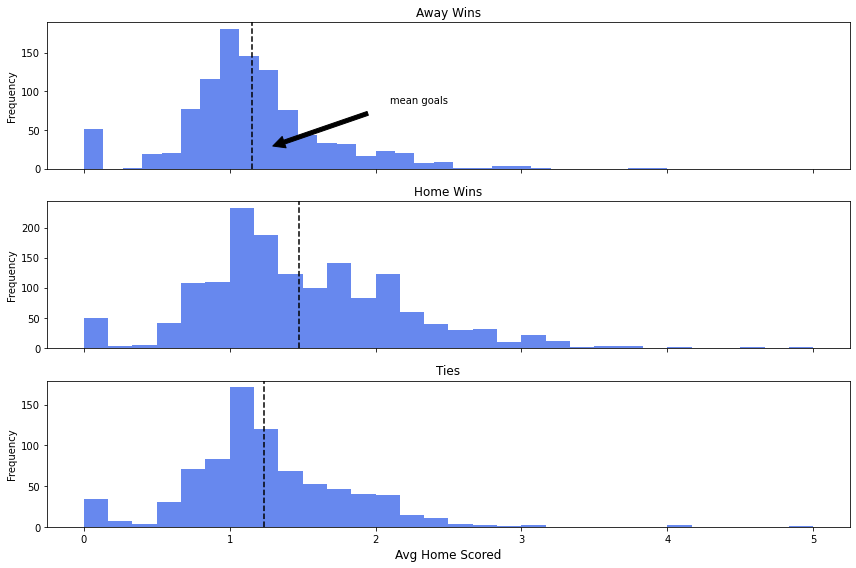

In [1280]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,8), sharex=True)
df.groupby('result')['home_avg_scored'].get_group('away').plot(kind="hist", ax=ax1, bins=30, title='Away Wins')
ax1.axvline(df.groupby('result')['home_avg_scored'].get_group('away').mean(), color='black', ls='--')
ax3.set_xlabel('Avg Home Scored', fontsize=12)

ax1.annotate('mean goals', xy=(df.groupby('result')['home_avg_scored'].get_group('away').mean(), 20),  xycoords='data',
            xytext=(0.5, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top',
            )
df.groupby('result')['home_avg_scored'].get_group('home').plot(kind="hist", ax=ax2, bins=30, title='Home Wins')
ax2.axvline(df.groupby('result')['home_avg_scored'].get_group('home').mean(), color='black', ls='--')
df.groupby('result')['home_avg_scored'].get_group('tie').plot(kind="hist", ax=ax3, bins=30, title='Ties')
ax3.axvline(df.groupby('result')['home_avg_scored'].get_group('tie').mean(), color='black', ls='--')
plt.tight_layout()
plt.show()

In [1281]:
anova('result', 'home_avg_scored', df)

(98.3665907373406, 3.135976114258634e-42)

Since this result is statistically significant , it shows that there is a relationship between match result and home avg scored

---

### Away average scored:

Null Hypothesis: There is no relationship between away average scored and result

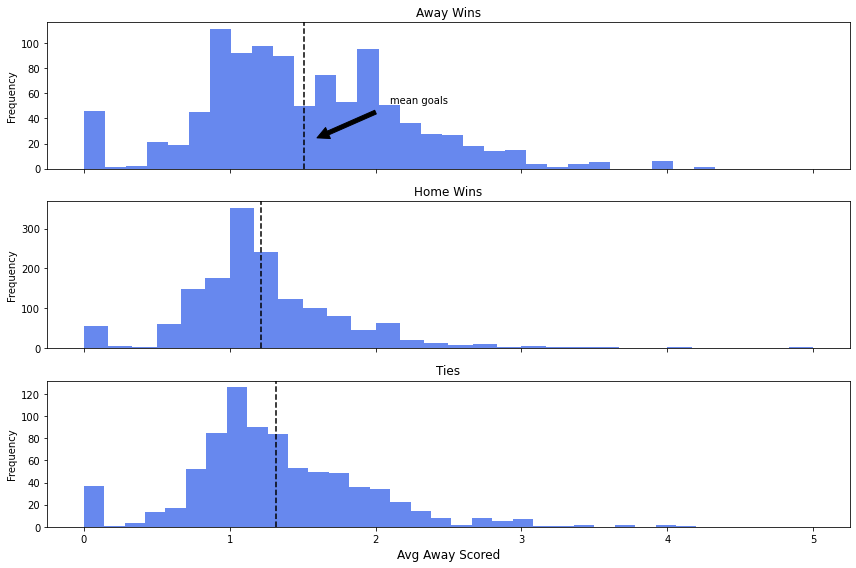

In [1282]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,8), sharex=True)
df.groupby('result')['away_avg_scored'].get_group('away').plot(kind="hist", ax=ax1, bins=30, title='Away Wins')
ax1.axvline(df.groupby('result')['away_avg_scored'].get_group('away').mean(), color='black', ls='--')
ax3.set_xlabel('Avg Away Scored', fontsize=12)

ax1.annotate('mean goals', xy=(df.groupby('result')['away_avg_scored'].get_group('away').mean(), 20),  xycoords='data',
            xytext=(0.5, 0.5), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.15),
            horizontalalignment='right', verticalalignment='top',
            )
df.groupby('result')['away_avg_scored'].get_group('home').plot(kind="hist", ax=ax2, bins=30, title='Home Wins')
ax2.axvline(df.groupby('result')['away_avg_scored'].get_group('home').mean(), color='black', ls='--')
df.groupby('result')['away_avg_scored'].get_group('tie').plot(kind="hist", ax=ax3, bins=30, title='Ties')
ax3.axvline(df.groupby('result')['away_avg_scored'].get_group('tie').mean(), color='black', ls='--')
plt.tight_layout()
plt.show()

In [1283]:
anova('result','away_avg_scored', df)

(70.1674563403321, 1.420307080223555e-30)

This is statistically significant. We will consider this variable.

In [1284]:
anova('result','home_avg_conceded',df)

(30.411273281265036, 8.164557858111995e-14)

In [1285]:
anova('result','away_avg_conceded',df)

(41.158165837137865, 2.2028032446322244e-18)

In [1286]:
anova('result','home_team_elo',df)

(169.63362868129298, 7.095563881392316e-71)

In [1287]:
anova('result','away_team_elo',df)

(161.0438765217114, 1.7536333085400753e-67)

In [1288]:
data = df[[ 'home_position','away_position','home_posse','away_posse','home_avg_scored', 'away_avg_scored', \
           'home_avg_conceded', 'away_avg_conceded', 'home_shotsON', 'away_shotsON', 'home_passes', 'away_passes',\
           "home_team_elo", 'away_team_elo', 'result','home_momentum','away_momentum','home_shots','away_shots']]

In [1289]:
data.head()

,home_position,away_position,home_posse,away_posse,home_avg_scored,away_avg_scored,home_avg_conceded,away_avg_conceded,home_shotsON,away_shotsON,home_passes,away_passes,home_team_elo,away_team_elo,result,home_momentum,away_momentum,home_shots,away_shots
0,0.0,0.0,52.0,48.0,0.0,0.0,0.0,0.0,2.0,4.0,330.0,298.0,1671.230347,1618.950073,away,NaN,NaN,17.0,15.0
1,0.0,0.0,54.1,45.9,0.0,0.0,0.0,0.0,5.0,1.0,419.0,352.0,1733.859863,1714.071289,tie,NaN,NaN,15.0,7.0
2,0.0,0.0,60.1,39.9,0.0,0.0,0.0,0.0,3.0,4.0,480.0,316.0,1789.441284,1651.818604,tie,NaN,NaN,14.0,14.0
3,0.0,0.0,37.8,62.2,0.0,0.0,0.0,0.0,1.0,2.0,320.0,548.0,1691.949463,1830.560181,tie,NaN,NaN,8.0,11.0
4,0.0,0.0,37.8,62.2,0.0,0.0,0.0,0.0,1.0,2.0,320.0,548.0,1565.246094,1646.411255,away,NaN,NaN,8.0,11.0


In [1290]:
data= data[data['home_position']!=0]

In [1291]:
data= data.reset_index(drop=True)

data['home_met'] = data['home_avg_scored']-data['home_avg_conceded']
data['home_met'].fillna(0, inplace=True)
data['away_met'] = data['away_avg_scored']-data['away_avg_conceded']
data['away_met'].fillna(0, inplace=True)


In [1292]:
pos= {1:20, 2:19, 3:18, 4:17, 5:16, 6:15, 7:14, 8:13, 9:12, 10:11, 11:10, 12:9, 13:8, 14:7, 15:6, 16:5, 17:4, 18:3, 19:2, 20:1}
data['home_position'] = data['home_position'].astype(int)
data['home_position']= data['home_position'].map(pos)
data['away_position'] = data['away_position'].astype(int)
data['away_position']= data['away_position'].map(pos)
data

,home_position,away_position,home_posse,away_posse,home_avg_scored,away_avg_scored,home_avg_conceded,away_avg_conceded,home_shotsON,away_shotsON,home_passes,away_passes,home_team_elo,away_team_elo,result,home_momentum,away_momentum,home_shots,away_shots
0,11,15,37.8,62.2,0.00,1.00,0.00,1.00,1.0,2.0,320.0,548.0,1835.281250,1789.096924,away,NaN,NaN,8.0,11.0
1,11,5,51.6,48.4,0.00,1.00,0.00,2.00,5.0,2.0,407.0,382.0,1721.689331,1665.080444,home,NaN,NaN,10.0,12.0
2,11,5,65.7,34.3,0.00,1.00,0.00,2.00,8.0,4.0,582.0,300.0,1879.835571,1663.468140,home,NaN,NaN,24.0,6.0
3,3,2,51.8,48.2,0.00,0.00,2.00,4.00,4.0,1.0,433.0,422.0,1770.490234,1554.769531,away,NaN,NaN,14.0,4.0
4,15,11,50.0,50.0,1.00,0.00,1.00,0.00,3.0,6.0,269.0,275.0,1662.250610,1698.895508,away,NaN,NaN,15.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,20,3,74.5,25.5,2.29,1.00,0.71,1.61,6.0,4.0,729.0,246.0,2048.104736,1640.572754,home,3.0,-2.0,14.0,6.0
3232,16,19,27.7,72.3,1.50,2.52,1.07,1.07,6.0,4.0,294.0,761.0,1827.580688,1993.183594,home,6.0,2.0,12.0,7.0
3233,13,1,41.8,58.2,1.07,0.89,0.93,1.82,4.0,5.0,359.0,519.0,1703.311646,1606.783569,home,1.0,-3.0,10.0,12.0
3234,8,7,38.0,62.0,1.25,0.86,1.82,1.46,3.0,7.0,298.0,500.0,1685.066162,1685.411377,away,-5.0,-5.0,6.0,14.0


In [1293]:
data.dropna(subset=['home_momentum', 'away_momentum'], inplace=True)

In [1294]:
result_map = {'tie':0, 'home':1, 'away':2}
data['result'] = data['result'].map(result_map)
data

,home_position,away_position,home_posse,away_posse,home_avg_scored,away_avg_scored,home_avg_conceded,away_avg_conceded,home_shotsON,away_shotsON,home_passes,away_passes,home_team_elo,away_team_elo,result,home_momentum,away_momentum,home_shots,away_shots
30,13,17,41.1,58.9,1.25,0.75,0.75,0.25,2.0,6.0,309.0,436.0,1731.443359,1715.592407,0,2.0,2.0,11.0,22.0
31,1,8,31.2,68.8,0.75,0.75,1.75,2.50,4.0,9.0,252.0,547.0,1657.924438,1825.620361,1,-4.0,-6.0,8.0,23.0
32,6,4,59.3,40.7,1.75,0.75,2.75,1.50,4.0,6.0,446.0,296.0,1654.044922,1560.231567,2,-1.0,-3.0,9.0,14.0
34,2,7,53.7,46.3,0.00,0.75,1.25,1.25,4.0,5.0,560.0,476.0,1588.273804,1662.985107,1,-5.0,-2.0,10.0,15.0
35,14,9,50.4,49.6,1.00,0.25,0.75,1.50,2.0,10.0,320.0,322.0,1647.202881,1568.602051,2,2.0,-5.0,15.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,20,3,74.5,25.5,2.29,1.00,0.71,1.61,6.0,4.0,729.0,246.0,2048.104736,1640.572754,1,3.0,-2.0,14.0,6.0
3232,16,19,27.7,72.3,1.50,2.52,1.07,1.07,6.0,4.0,294.0,761.0,1827.580688,1993.183594,1,6.0,2.0,12.0,7.0
3233,13,1,41.8,58.2,1.07,0.89,0.93,1.82,4.0,5.0,359.0,519.0,1703.311646,1606.783569,1,1.0,-3.0,10.0,12.0
3234,8,7,38.0,62.0,1.25,0.86,1.82,1.46,3.0,7.0,298.0,500.0,1685.066162,1685.411377,2,-5.0,-5.0,6.0,14.0


In [1295]:
data.isnull().sum()

home_position        0
away_position        0
home_posse           0
away_posse           0
home_avg_scored      0
away_avg_scored      0
home_avg_conceded    0
away_avg_conceded    0
home_shotsON         0
away_shotsON         0
home_passes          0
away_passes          0
home_team_elo        0
away_team_elo        0
result               0
home_momentum        0
away_momentum        0
home_shots           0
away_shots           0
dtype: int64

In [1296]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2965 entries, 30 to 3235
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   home_position      2965 non-null   int64  
 1   away_position      2965 non-null   int64  
 2   home_posse         2965 non-null   float64
 3   away_posse         2965 non-null   float64
 4   home_avg_scored    2965 non-null   float64
 5   away_avg_scored    2965 non-null   float64
 6   home_avg_conceded  2965 non-null   float64
 7   away_avg_conceded  2965 non-null   float64
 8   home_shotsON       2965 non-null   float64
 9   away_shotsON       2965 non-null   float64
 10  home_passes        2965 non-null   float64
 11  away_passes        2965 non-null   float64
 12  home_team_elo      2965 non-null   float64
 13  away_team_elo      2965 non-null   float64
 14  result             2965 non-null   int64  
 15  home_momentum      2965 non-null   float64
 16  away_momentum      2965

#data['home_performance_last_five']= data['home_performance_last_five'].astype('float')
#data['away_performance_last_five']= data['away_performance_last_five'].astype('float') 

In [1303]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

X= data.drop('result', axis=1)
y= data['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

model = RandomForestClassifier()
cl_cval = cross_val_score(model, X_train, y_train, cv=5)
cl_cval.mean()

0.5864188318898512

In [1304]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.596964586846543

Text(0.5, 15.0, 'Predicted')

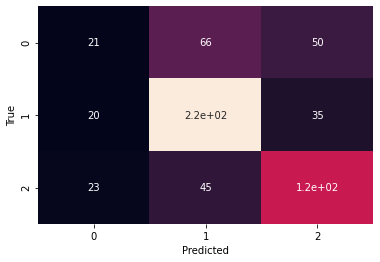

In [1305]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')

In [1306]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.15      0.21       137
           1       0.66      0.80      0.72       271
           2       0.58      0.63      0.60       185

    accuracy                           0.60       593
   macro avg       0.52      0.53      0.51       593
weighted avg       0.56      0.60      0.57       593



In [1307]:
from sklearn.model_selection import RandomizedSearchCV

cl = RandomForestClassifier()
param_grid = {'n_estimators': range(100, 200, 20),
             'max_depth': range(7, 9, 1),
             'ccp_alpha':[0, 0.1],
              'criterion':['gini','entropy'],
              'max_features': ['auto', 'sqrt', 'log2'],
              
             }

cl_cv= RandomizedSearchCV(cl,param_grid, cv=5 )
cl_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'ccp_alpha': [0, 0.1],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(7, 9),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': range(100, 200, 20)})

In [1308]:
cl_cv.best_params_

{'n_estimators': 180,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'entropy',
 'ccp_alpha': 0}

In [1309]:
model= RandomForestClassifier(n_estimators=180, max_features='auto', criterion='entropy',max_depth=8, ccp_alpha=0)
model.fit(X_train, y_train)
y_pred= model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6037099494097807

Text(0.5, 15.0, 'Predicted')

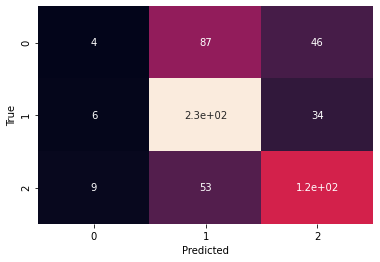

In [1310]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')

In [1311]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.03      0.05       137
           1       0.62      0.85      0.72       271
           2       0.61      0.66      0.63       185

    accuracy                           0.60       593
   macro avg       0.48      0.52      0.47       593
weighted avg       0.52      0.60      0.54       593



In [1312]:
model.feature_importances_

array([0.04309575, 0.03720673, 0.04720598, 0.0453183 , 0.05809178,
       0.05331254, 0.03897774, 0.03913523, 0.10809657, 0.12868153,
       0.05051471, 0.05543392, 0.07727293, 0.0778398 , 0.02860529,
       0.03876245, 0.03409152, 0.03835721])

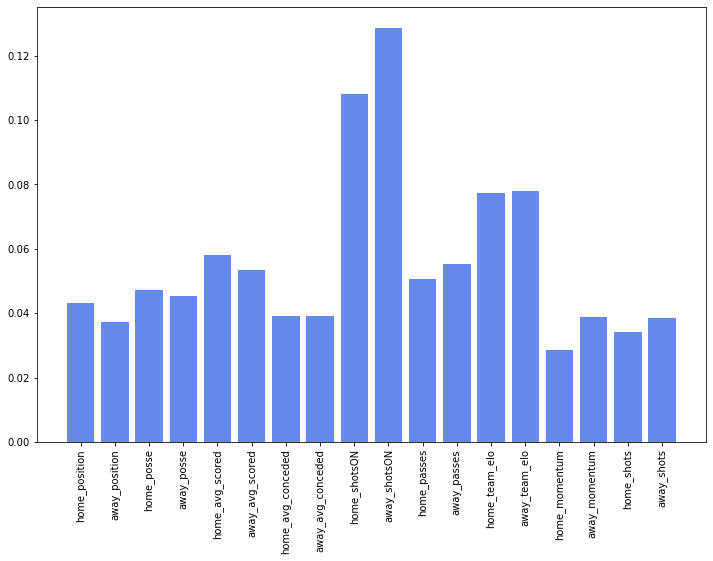

In [1313]:
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(data.columns.drop('result'), model.feature_importances_)
plt.xticks(rotation=90);


***


**Missing Values**

***

- The date, and kickoff columns have some null values. These columns might be indicative of weather conditions, which is a feature we might look at adding later on.


- home_performance_last_five and away_performance_last_five have the same number of null values because this feature requires the first 5 games of the season to be completed before a relevant value can be calculated.


- home_goals and away_goals have some missing values as well. These might be matches where no goals were scored. This needs to be verified before these values are converted to 0.


- home_yellow_pl,away_yellow_pl,home_red_pl,away_red_pl have null values as well. This can be matches where there were no yellow or red cards given. This again needs to be verified before imputation can be done.


- home_lineup and away_lineup have some missing values as well. These need to be investigated and possibly imputed to be able to understand which players actually played the game. This might be a very important feature.
   